In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
from sklearn.neighbors import NearestCentroid
from math import pi
from sklearn.cluster import AgglomerativeClustering

### Functions to describe clusters

In [2]:
def plot_parallel_coordinates_clusters(df, cluster_centers):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(cluster_centers)):
        plt.plot(cluster_centers[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
    plt.legend(fontsize=10)
    plt.show()

In [3]:
def plot_radar_clusters(df, cluster_centers):
    # number of variable
    N = len(df.columns)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    for i in range(0, len(cluster_centers)):
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values = cluster_centers[i].tolist()
        values += values[:1]
        angles += angles[:1]
        # Initialise the spider plot
        ax = plt.subplot(polar=True)
        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
        # Plot data
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        # Fill area
        ax.fill(angles, values, 'b', alpha=0.1)

In [4]:
def plot_date_feature_clusters(df, labels, num_cluster):

    for i in range(num_cluster):
        i_samples = labels==i
        df_cat[i_samples].name.groupby(pd.to_datetime(df_cat.loc[i_samples, 'created_at'], format='%Y-%m-%d %H:%M:%S', errors='raise').dt.year).count().plot(kind="bar")
        plt.show()

In [5]:
def categorical_hist_clusters(df, labels, feature_name):
    bot_xt_pct = pd.crosstab(labels, df[feature_name])
    bot_xt_pct.plot(kind='bar', stacked=False, 
                       title=f'{feature_name} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature_name)
    plt.show()

In [6]:
def plot_numerical_features_clusters(df, labels, num_cluster):
    """
    print and plot distribution of numerical features conditioned by the cluster
    """
    
    for i in range(num_cluster):
        i_samples = labels==i
        df[i_samples].boxplot()
        df[i_samples].hist()
        plt.show()

In [7]:
def scatter_features_clusters(df, labels):
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            feature_1 = df.columns[i]
            feature_2 = df.columns[j]
            
            print(f"{feature_1} - {feature_2}")
            plt.scatter(df[feature_1], df[feature_2], c=labels, s=20)
            plt.tick_params(axis='both', which='major', labelsize=22)
            plt.show()

### Preparation of the dataset

In [8]:
df = pd.read_csv("dataset/user_profiles.csv", skipinitialspace=True, sep=',')

In [9]:
df.head()

Unnamed: 0              name lang  bot           created_at  \
0  2353593986   Lamonica Raborn   en    1  2019-02-22 18:00:42   
1  2358850842     Lourie Botton   en    0  2019-02-26 03:02:32   
2   137959629  Dadan Syarifudin   en    1  2015-04-30 07:09:56   
3   466124818    Carletto Focia   it    1  2017-01-18 02:49:18   
4  2571493866         MBK Ebook   en    0  2019-06-18 19:30:21   

   statuses_count  avg_length  avg_special_chars  urls_ratio  mentions_ratio  \
0              76   62.340909          14.015152    0.000000        0.272727   
1               4   69.082645          15.041322    0.000000        0.338843   
2               7   19.250000           5.250000    0.000000        0.000000   
3              50   86.944871          18.689463    0.022331        0.006281   
4               8   72.311246          14.582073    0.000825        0.506461   

   hashtags_ratio  reply_count_mean  reply_count_std  reply_count_entropy  \
0        0.098485               0.0              0.0                  0.0   
1        0.024793               0.0              0.0                  0.0   
2        0.000000               0.0              0.0                  0.0   
3        0.072575               0.0              0.0                  0.0   
4        0.118229               0.0              0.0                  0.0   

   favorite_count_mean  favorite_count_std  favorite_count_entropy  \
0             0.037879            0.190903                1.609438   
1             0.049587            0.217090                1.791759   
2             0.000000            0.000000                0.000000   
3             0.165387            0.530838                5.105129   
4             0.056365            0.243387                5.248623   

   retweet_count_mean  retweet_count_std  retweet_count_entropy  
0            0.037879           0.190903               1.609438  
1            0.024793           0.155495               1.098612  
2            0.000000           0.000000               0.000000  
3            0.826239          13.034008               2.170410  
4            0.016772           0.142619               3.965939

In [10]:
df_cat = df[['name','lang','created_at', 'bot']]
del df['name']
del df['lang']
del df['created_at']
del df['bot']
df.head()

Unnamed: 0  statuses_count  avg_length  avg_special_chars  urls_ratio  \
0  2353593986              76   62.340909          14.015152    0.000000   
1  2358850842               4   69.082645          15.041322    0.000000   
2   137959629               7   19.250000           5.250000    0.000000   
3   466124818              50   86.944871          18.689463    0.022331   
4  2571493866               8   72.311246          14.582073    0.000825   

   mentions_ratio  hashtags_ratio  reply_count_mean  reply_count_std  \
0        0.272727        0.098485               0.0              0.0   
1        0.338843        0.024793               0.0              0.0   
2        0.000000        0.000000               0.0              0.0   
3        0.006281        0.072575               0.0              0.0   
4        0.506461        0.118229               0.0              0.0   

   reply_count_entropy  favorite_count_mean  favorite_count_std  \
0                  0.0             0.037879            0.190903   
1                  0.0             0.049587            0.217090   
2                  0.0             0.000000            0.000000   
3                  0.0             0.165387            0.530838   
4                  0.0             0.056365            0.243387   

   favorite_count_entropy  retweet_count_mean  retweet_count_std  \
0                1.609438            0.037879           0.190903   
1                1.791759            0.024793           0.155495   
2                0.000000            0.000000           0.000000   
3                5.105129            0.826239          13.034008   
4                5.248623            0.016772           0.142619   

   retweet_count_entropy  
0               1.609438  
1               1.098612  
2               0.000000  
3               2.170410  
4               3.965939

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [12]:
scaler = StandardScaler()
scaler.fit(df.values)
X = scaler.fit_transform(df.values)

In [13]:
X[:5]

array([[ 1.15363293,  0.33593189, -0.35784931, -0.26859356, -0.47751096,
        -0.22247583, -0.19834274, -0.08312265, -0.12432158, -0.24648729,
        -0.2547907 , -0.34893963, -0.45495561, -0.33164564, -0.61495354,
        -0.30601295],
       [ 1.15925299, -0.58101623,  0.05815912, -0.08056663, -0.47751096,
        -0.0397904 , -0.54486366, -0.08312265, -0.12432158, -0.24648729,
        -0.24023803, -0.32378925, -0.37748204, -0.33272276, -0.61646742,
        -0.55341544],
       [-1.21508478, -0.54281006, -3.01683541, -1.8746464 , -0.47751096,
        -0.97605324, -0.66145014, -0.08312265, -0.12432158, -0.24648729,
        -0.30187286, -0.53228851, -1.13885118, -0.33476361, -0.62311564,
        -1.08549411],
       [-0.86424589,  0.00481174,  1.16037331,  0.58788801, -0.35248456,
        -0.9586994 , -0.32017909, -0.08312265, -0.12432158, -0.24648729,
        -0.09630158, -0.02245647,  1.03046228, -0.2667522 , -0.06584438,
        -0.03432346],
       [ 1.38658802, -0.53007467,  0

# Hierarchical Clustering

In [14]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [15]:
metric = ['canberra', 'chebyshev', 'cityblock', 'correlation', 'dice', 'hamming', 'jaccard', 'jensenshannon', 'kulczynski1', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'cosine', 'euclidean']
method = ['single', 'average', 'complete']

##### Canberra

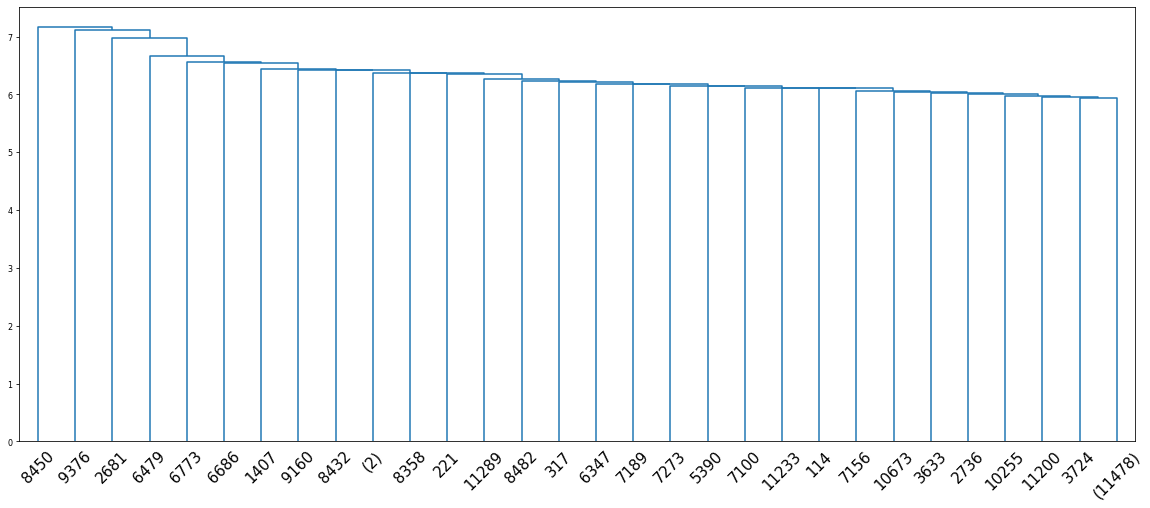

In [30]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[0], metric=metric[0])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

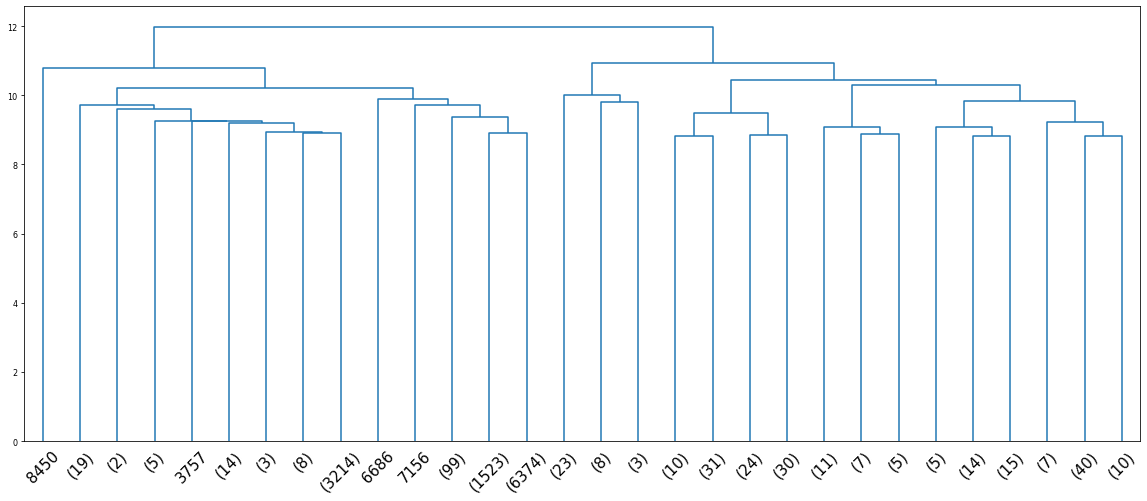

In [31]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[1], metric=metric[0])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

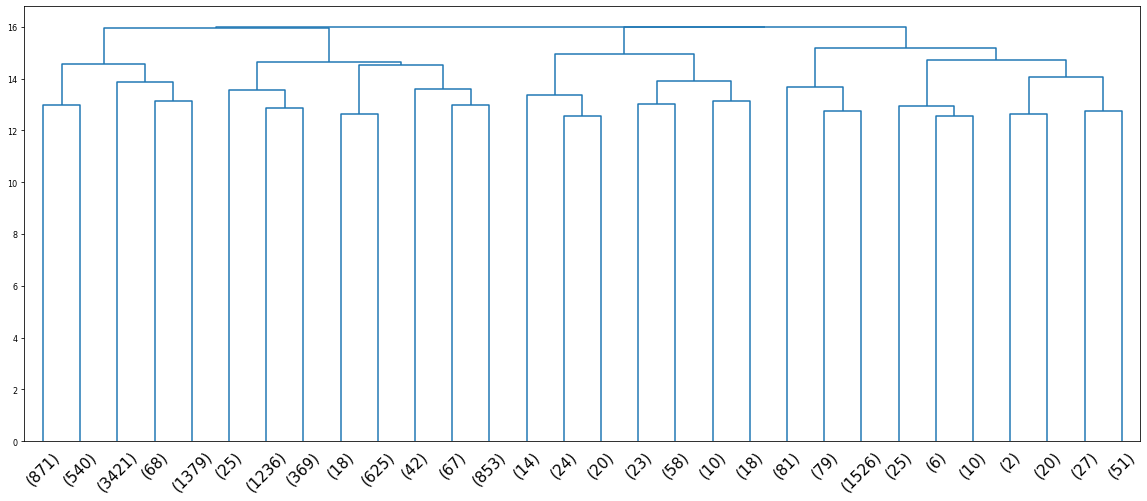

In [32]:
data_dist = pdist(X, metric=metric[0])
data_link = linkage(data_dist, method=method[2], metric=metric[0])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### chebyshev

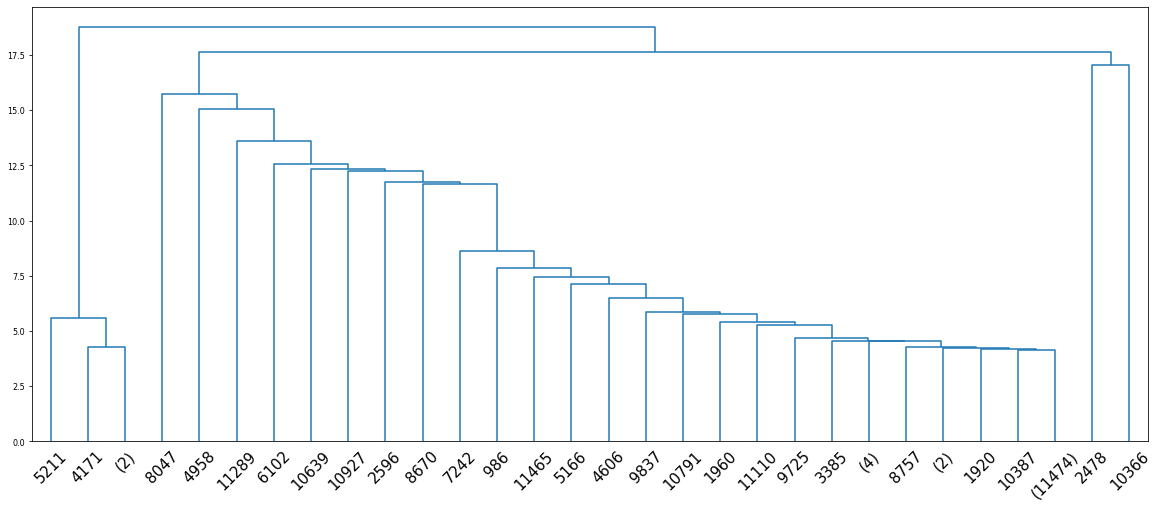

In [33]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[0], metric=metric[1])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

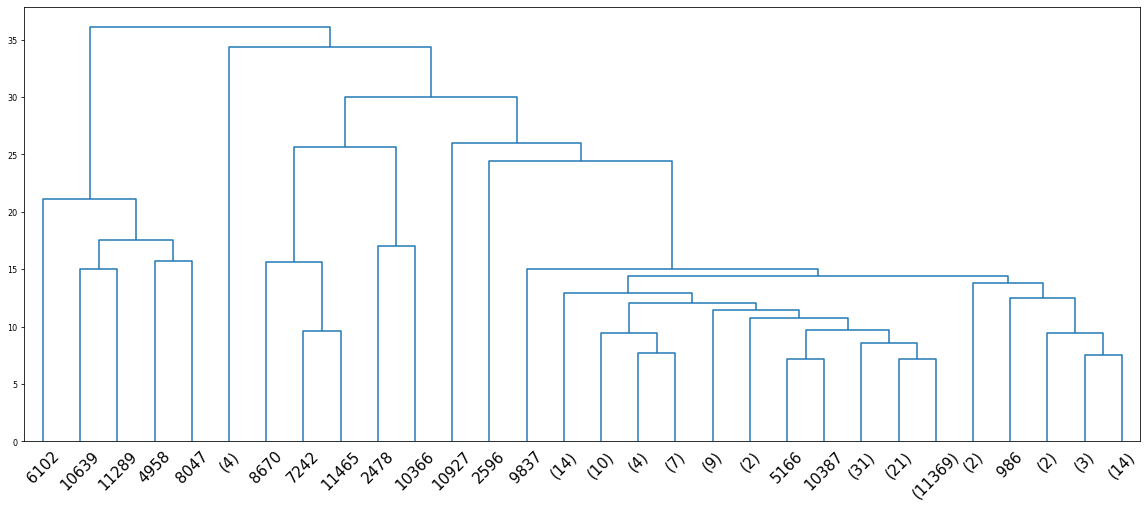

In [34]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[1], metric=metric[1])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

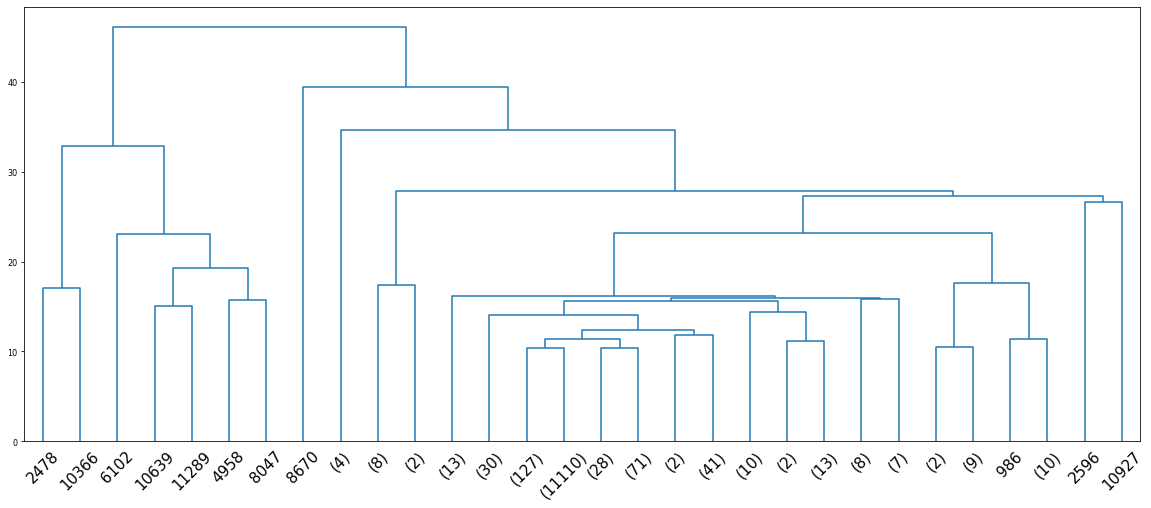

In [35]:
data_dist = pdist(X, metric=metric[1])
data_link = linkage(data_dist, method=method[2], metric=metric[1])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### cityblock

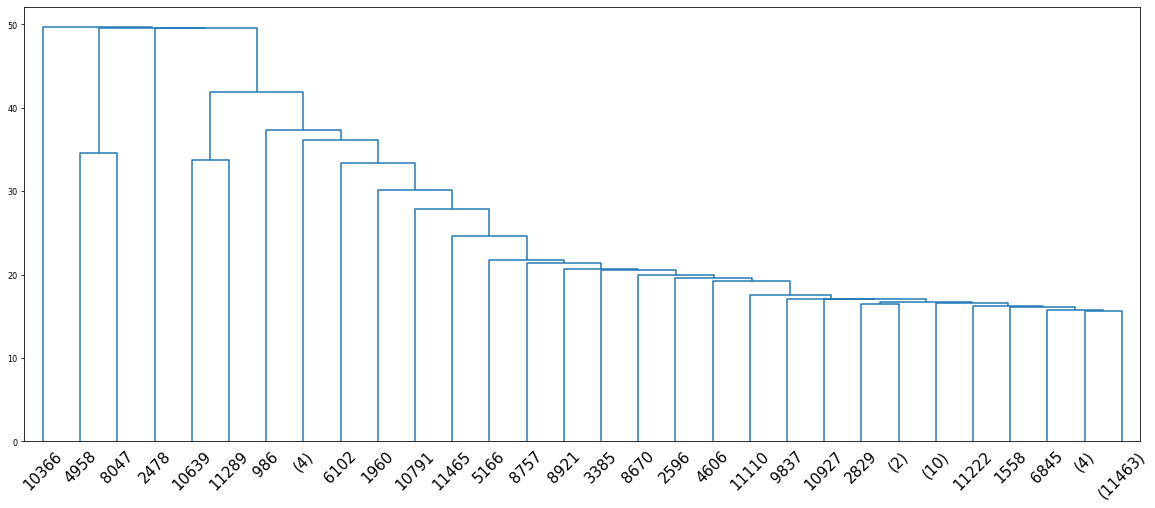

In [36]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[0], metric=metric[2])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

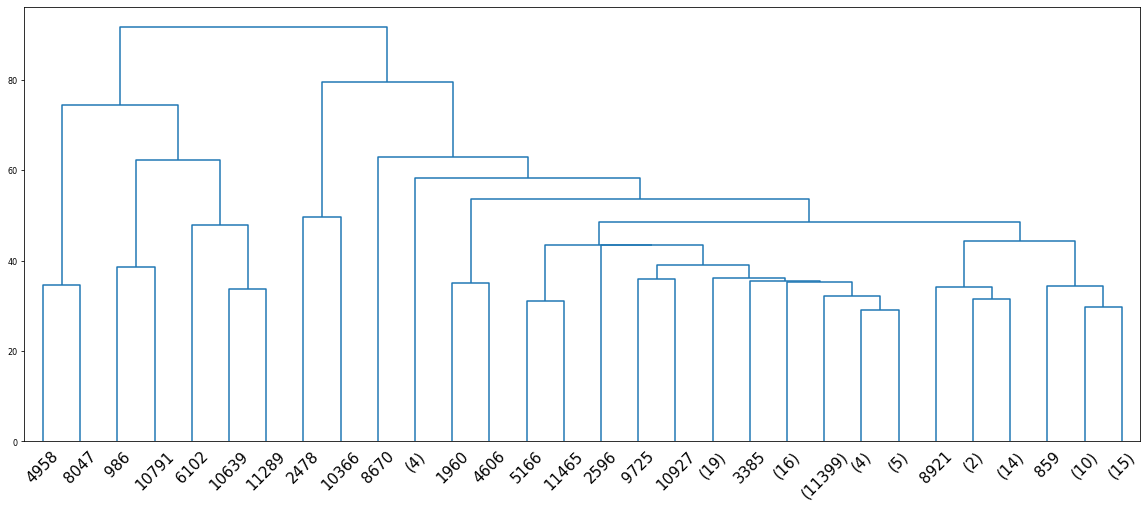

In [37]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[1], metric=metric[2])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

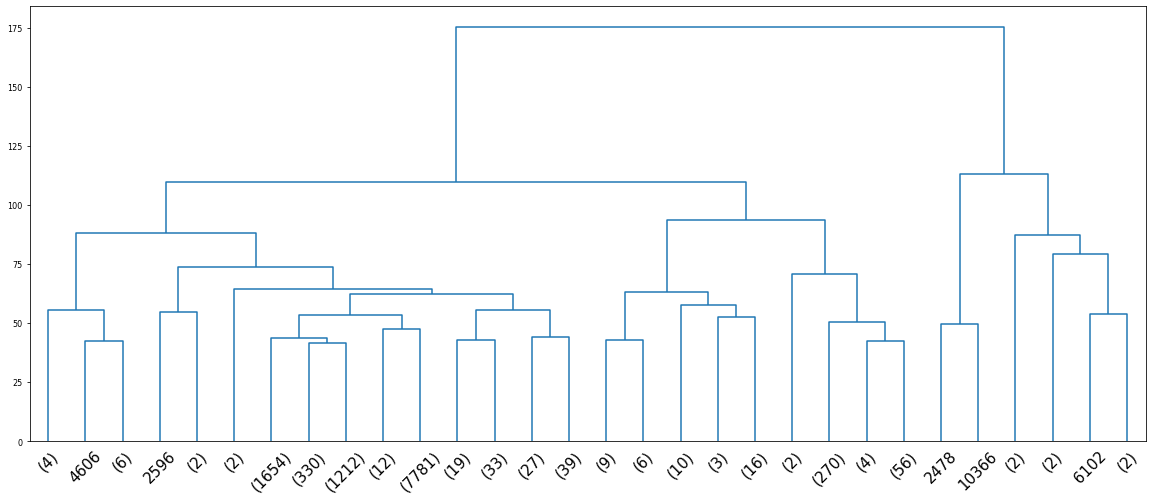

In [38]:
data_dist = pdist(X, metric=metric[2])
data_link = linkage(data_dist, method=method[2], metric=metric[2])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### correlation

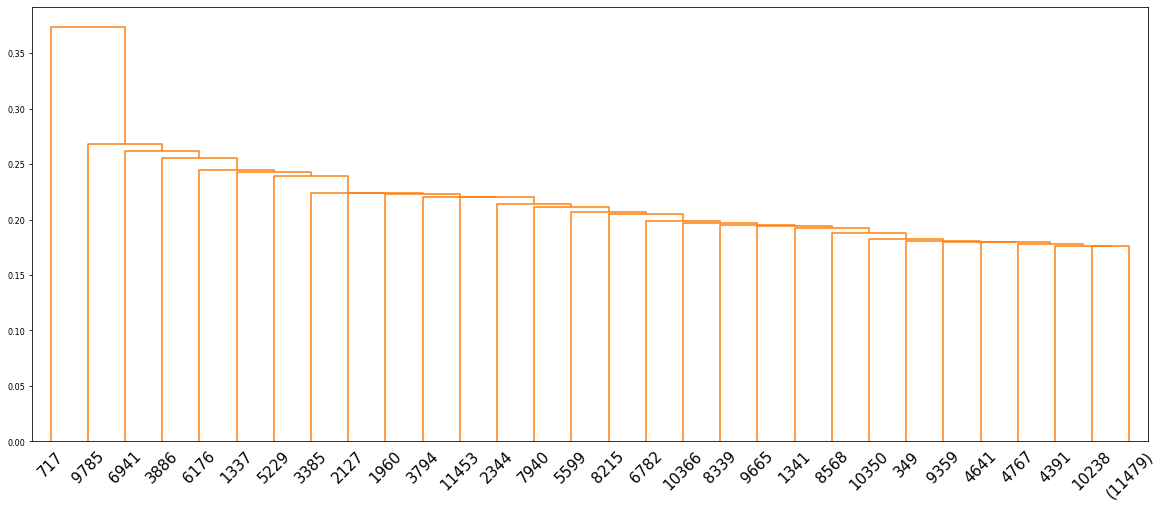

In [39]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[0], metric=metric[3])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

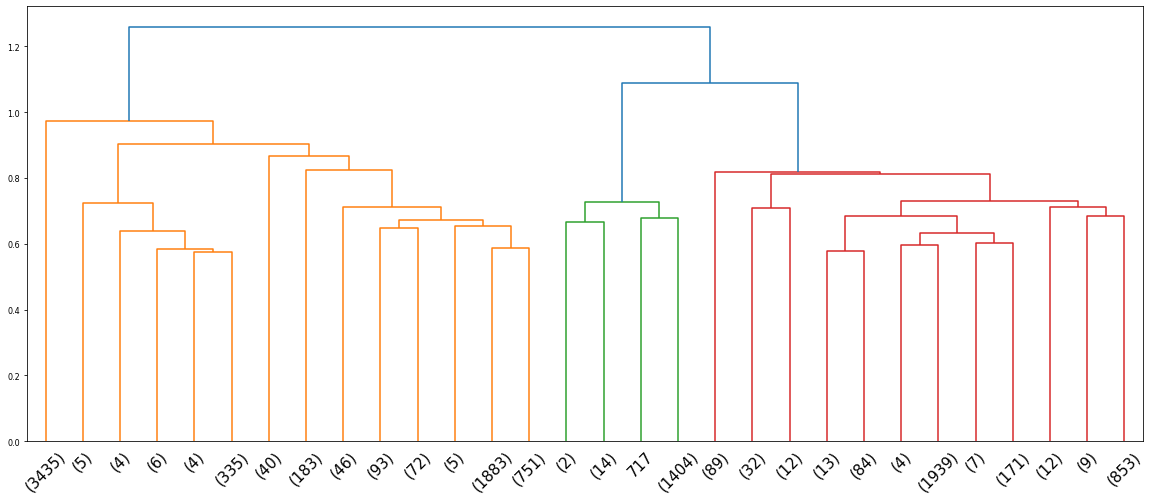

In [40]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[1], metric=metric[3])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

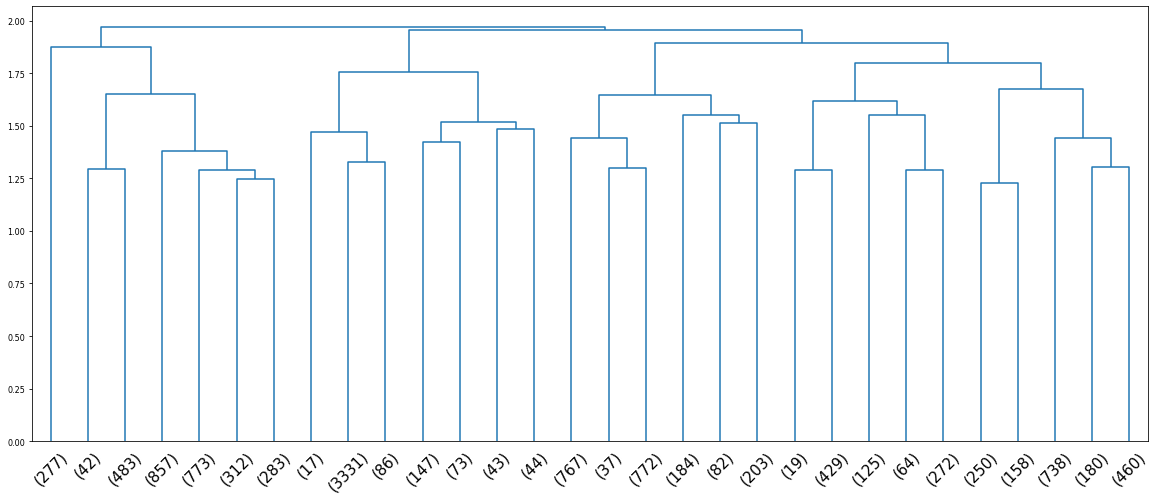

In [41]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method=method[2], metric=metric[3])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

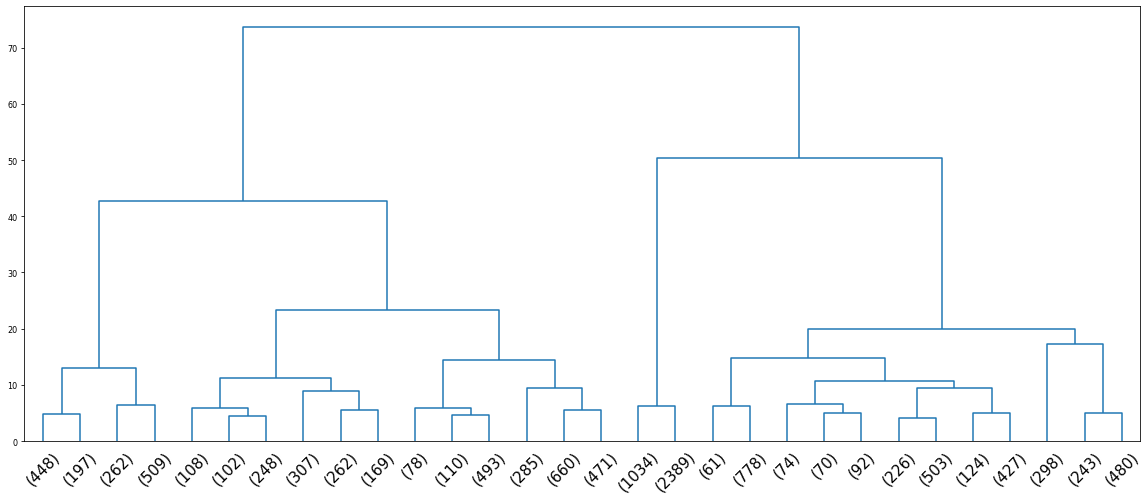

In [20]:
data_dist = pdist(X, metric=metric[3])
data_link = linkage(data_dist, method='ward', metric=metric[3])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### dice

C:\Users\espos\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


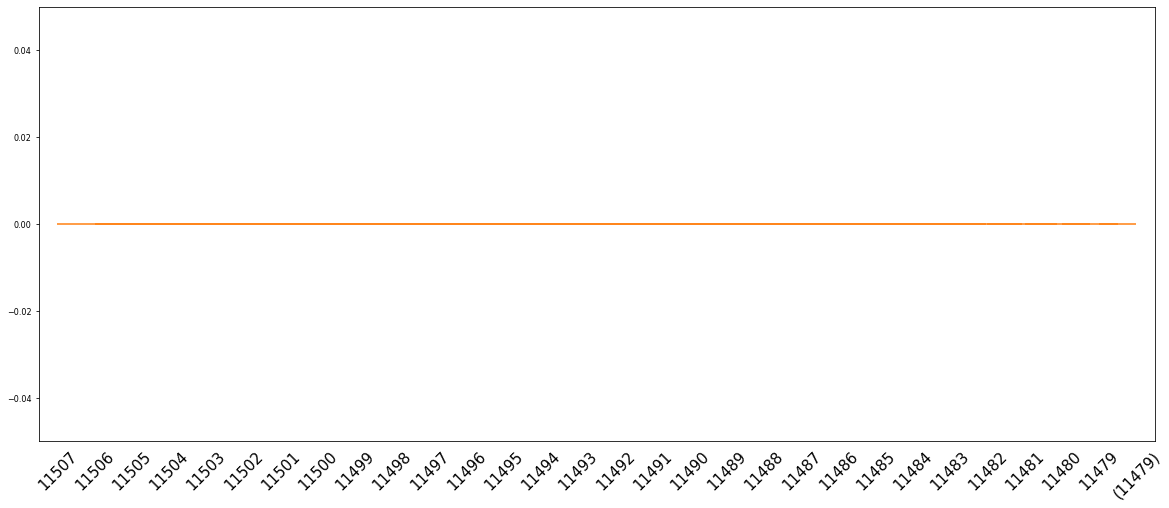

In [42]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[0], metric=metric[4])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

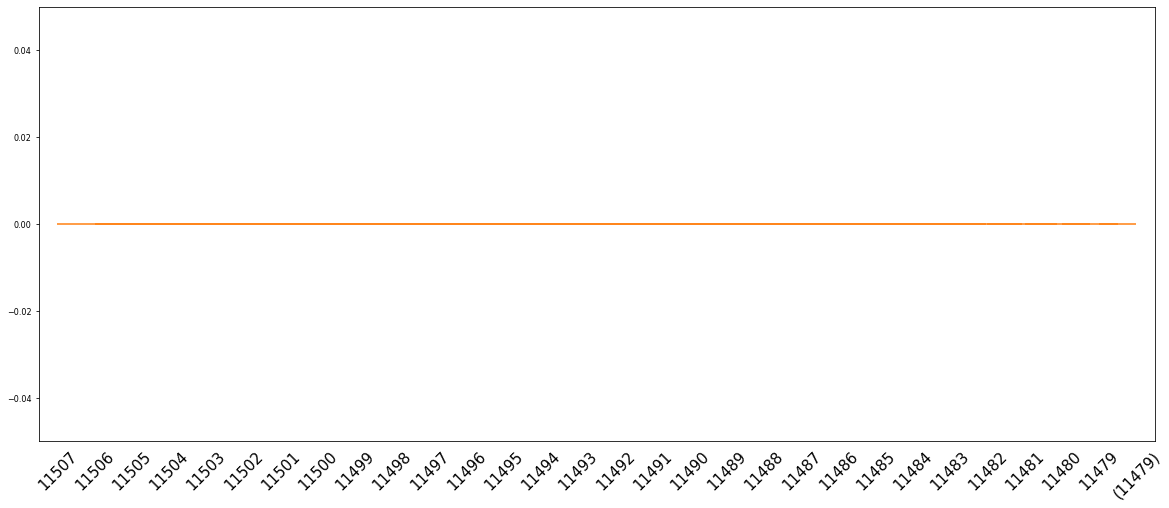

In [43]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[1], metric=metric[4])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

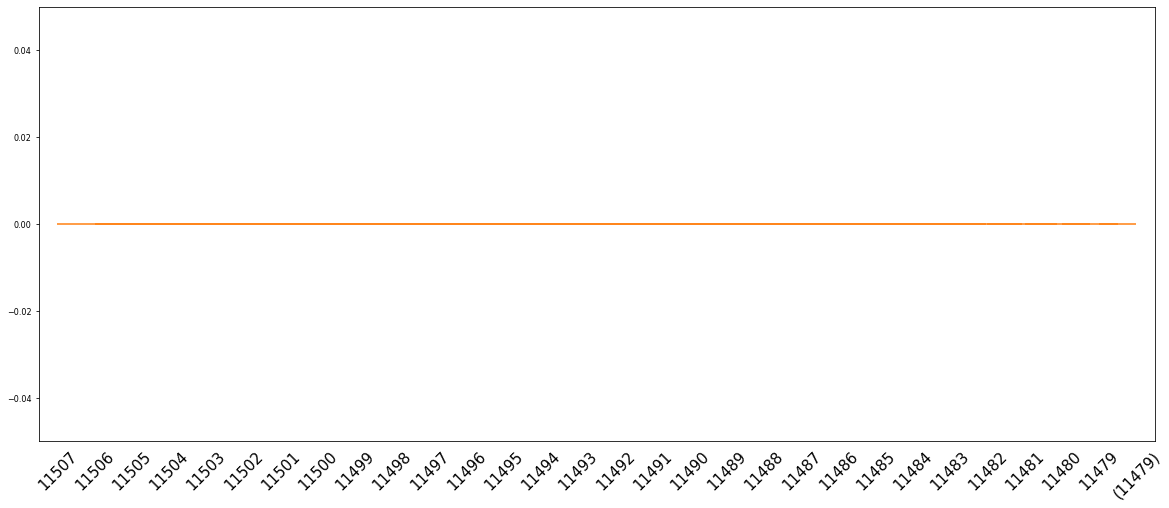

In [44]:
data_dist = pdist(X, metric=metric[4])
data_link = linkage(data_dist, method=method[2], metric=metric[4])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### hamming

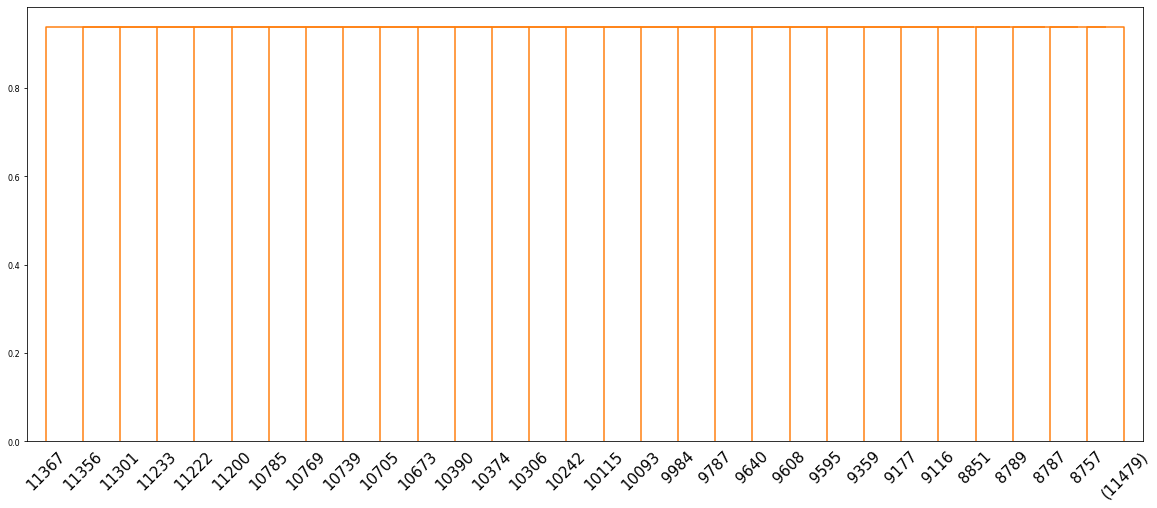

In [45]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[0], metric=metric[5])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

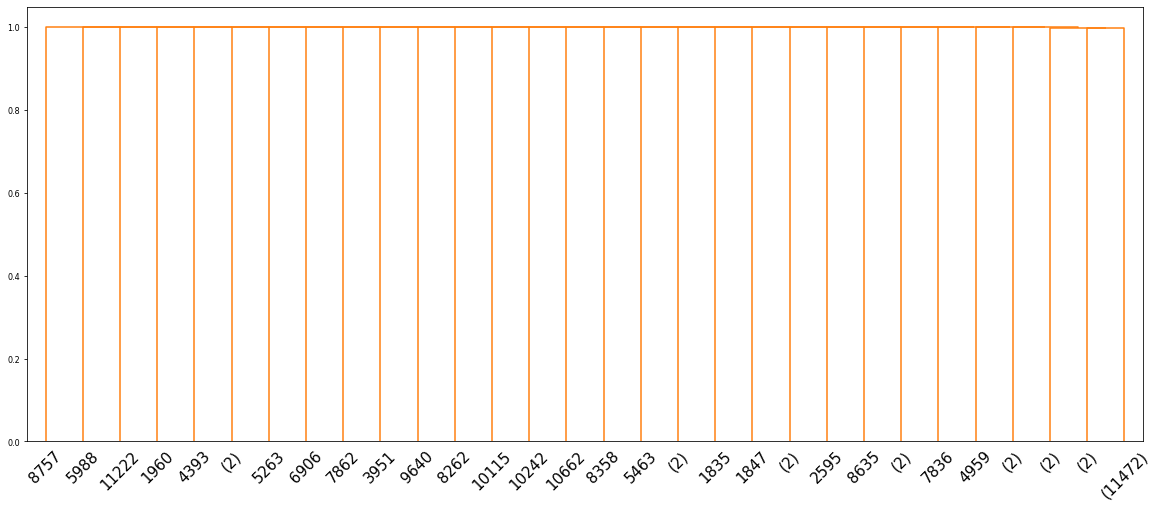

In [46]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[1], metric=metric[5])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

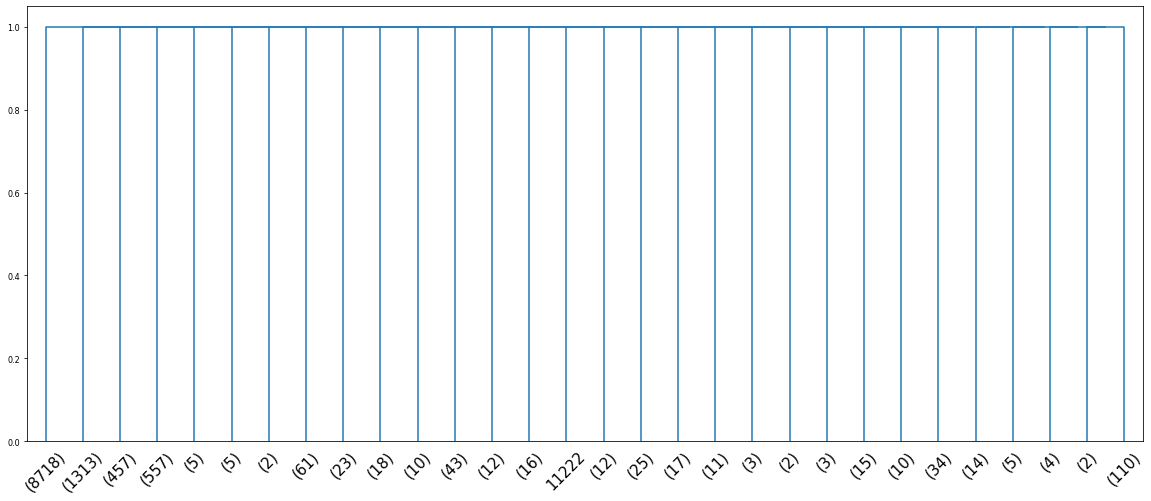

In [47]:
data_dist = pdist(X, metric=metric[5])
data_link = linkage(data_dist, method=method[2], metric=metric[5])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

###### jaccard

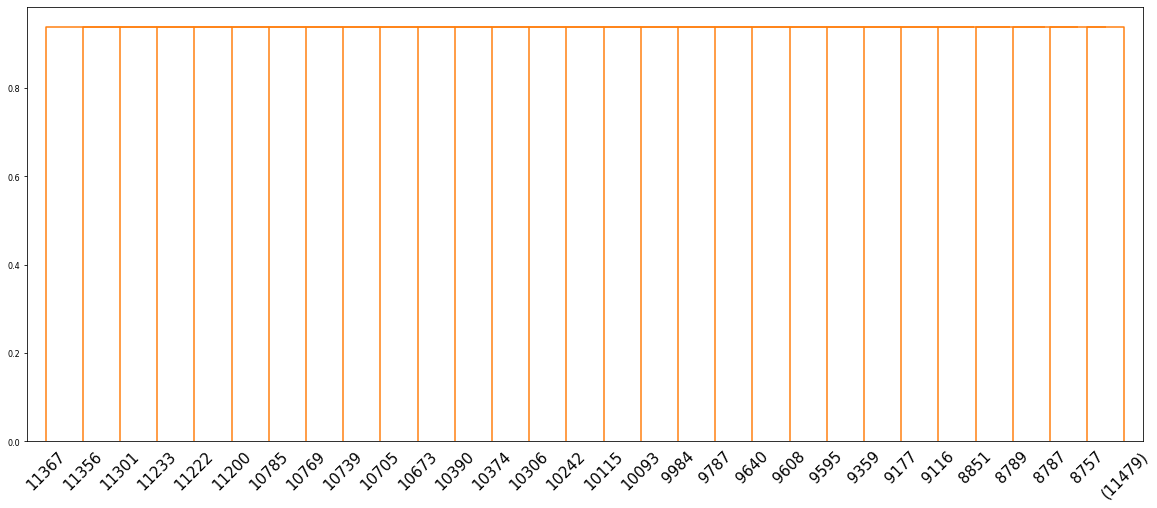

In [48]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[0], metric=metric[6])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

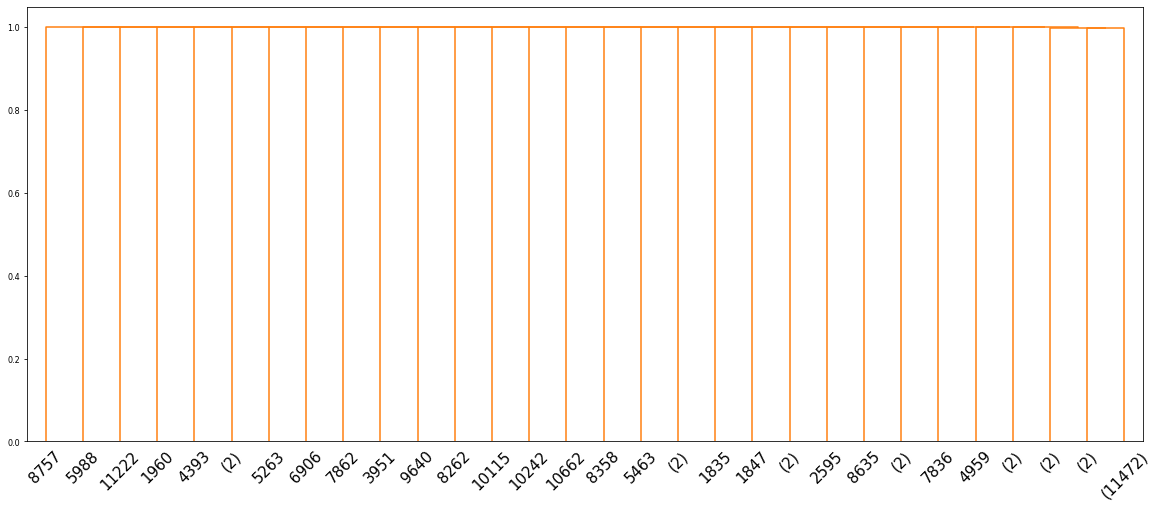

In [49]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[1], metric=metric[6])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

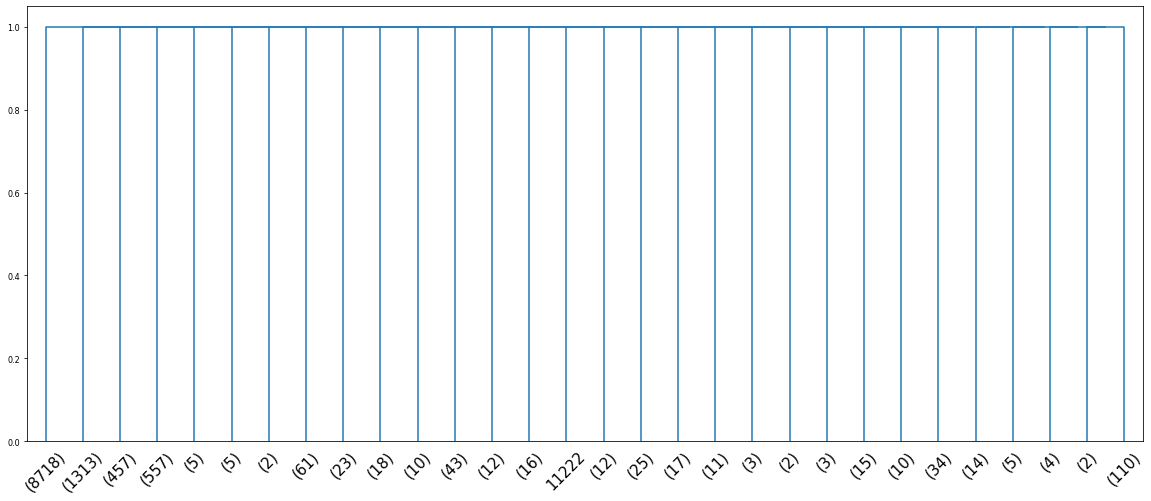

In [50]:
data_dist = pdist(X, metric=metric[6])
data_link = linkage(data_dist, method=method[2], metric=metric[6])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### jensenshannon (solo numeri finiti)

In [51]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[0], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[7])\ndata_link = linkage(data_dist, method=method[0], metric=metric[7])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

In [52]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[1], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[7])\ndata_link = linkage(data_dist, method=method[1], metric=metric[7])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

In [53]:
'''data_dist = pdist(X, metric=metric[7])
data_link = linkage(data_dist, method=method[2], metric=metric[7])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[7])\ndata_link = linkage(data_dist, method=method[2], metric=metric[7])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

##### kulczynski1 (sconosciuto)

In [54]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[0], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[8])\ndata_link = linkage(data_dist, method=method[0], metric=metric[8])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

In [55]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[1], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[8])\ndata_link = linkage(data_dist, method=method[1], metric=metric[8])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

In [56]:
'''data_dist = pdist(X, metric=metric[8])
data_link = linkage(data_dist, method=method[2], metric=metric[8])
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')'''

"data_dist = pdist(X, metric=metric[8])\ndata_link = linkage(data_dist, method=method[2], metric=metric[8])\nres = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')"

##### mahalanobis

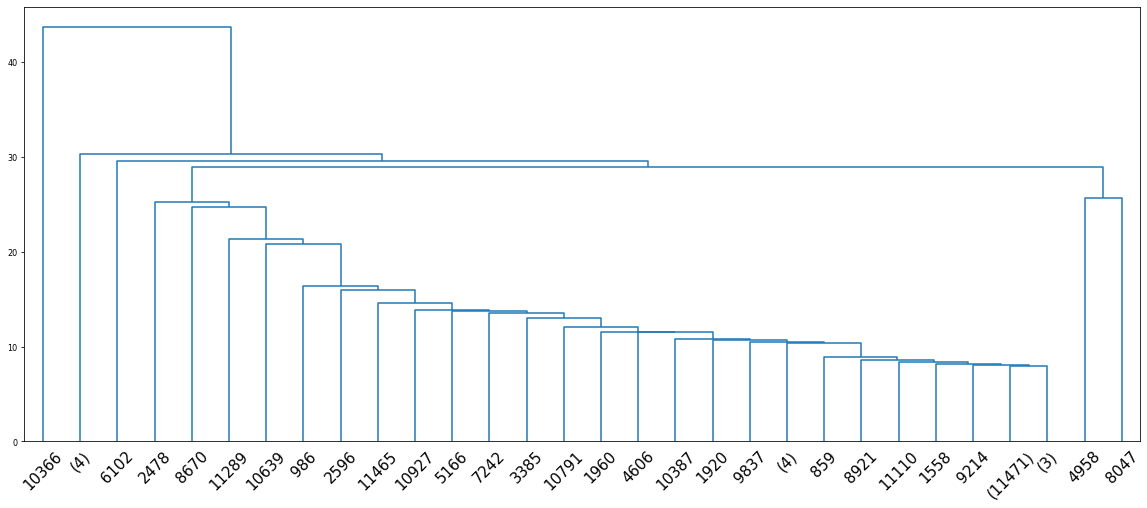

In [57]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[0], metric=metric[9])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

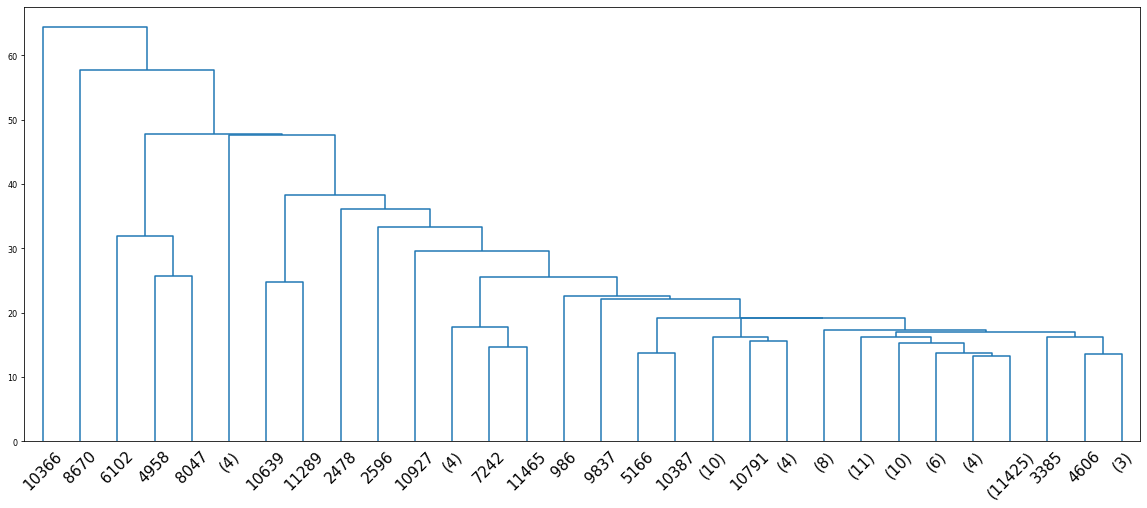

In [58]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[1], metric=metric[9])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

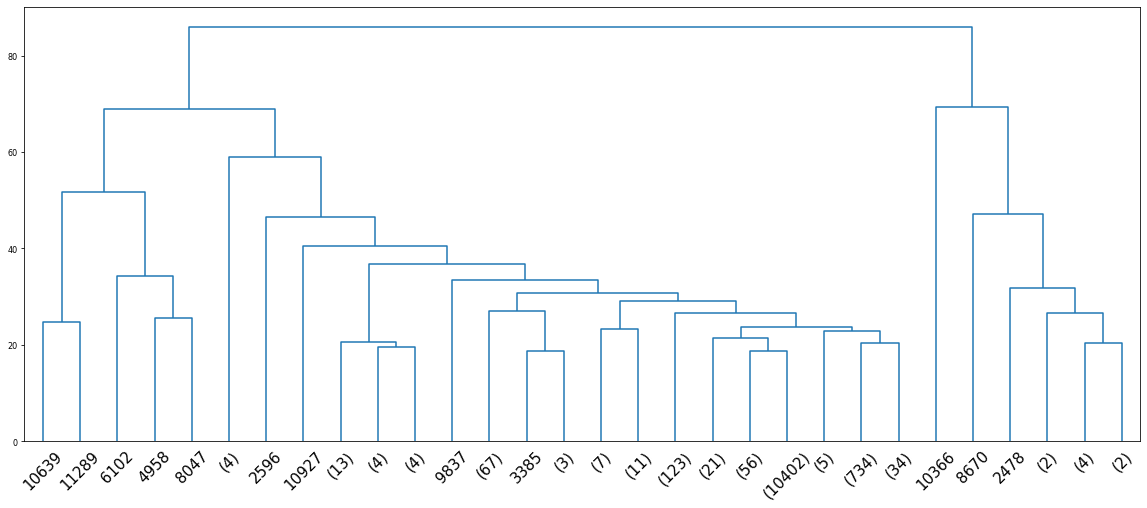

In [59]:
data_dist = pdist(X, metric=metric[9])
data_link = linkage(data_dist, method=method[2], metric=metric[9])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

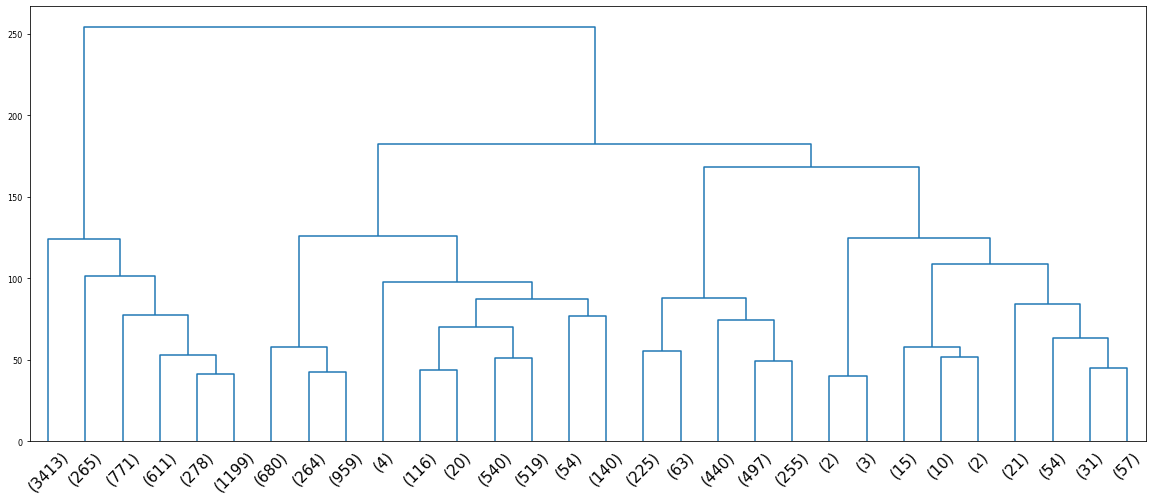

In [19]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method='ward', metric=metric[11])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### matching

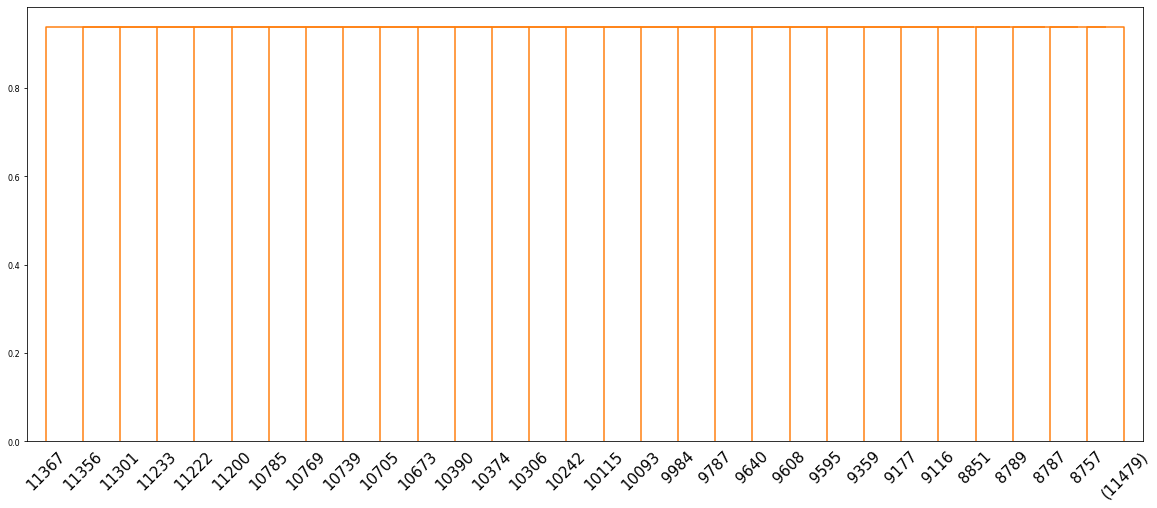

In [60]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[0], metric=metric[10])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

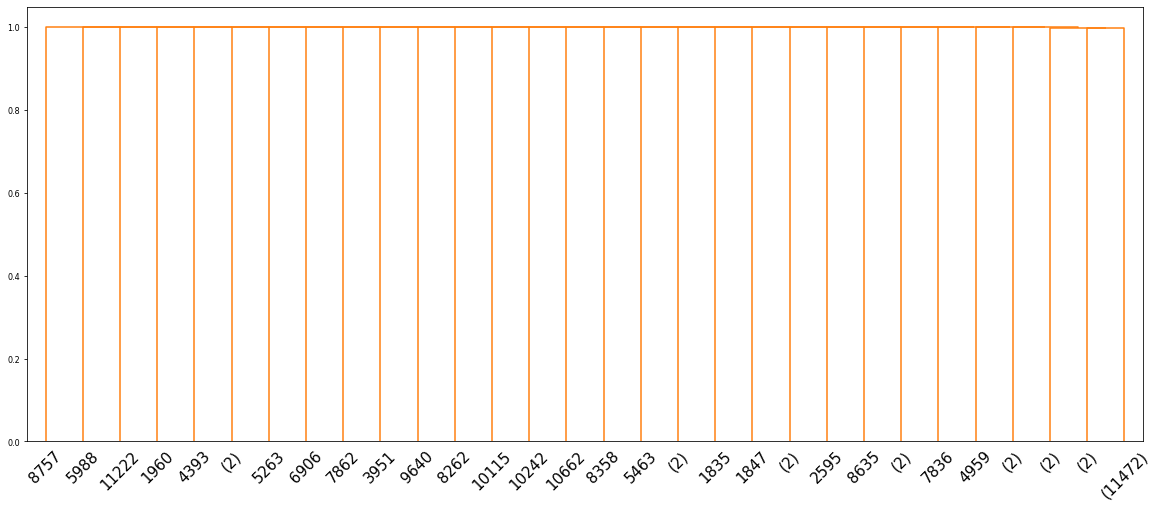

In [61]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[1], metric=metric[10])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

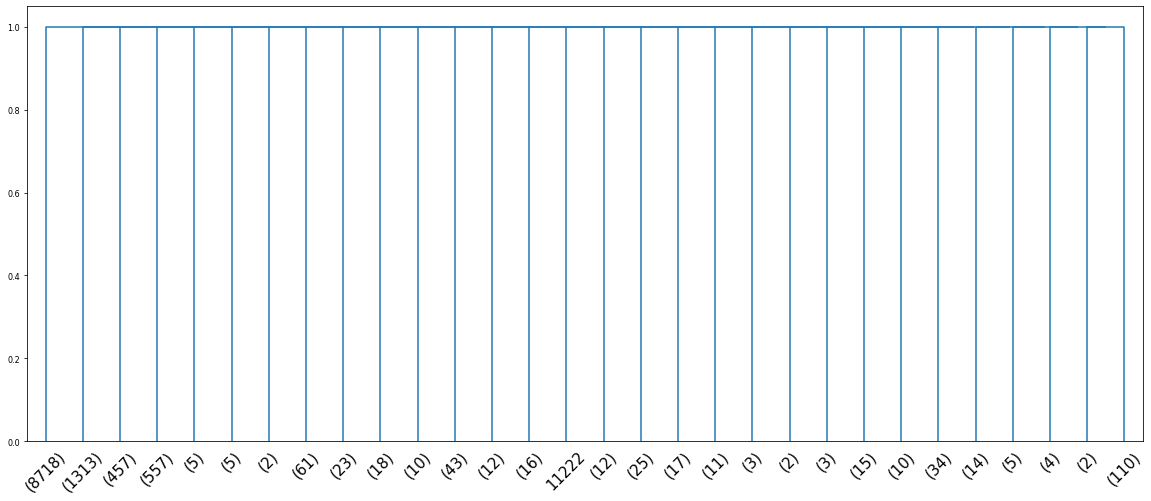

In [62]:
data_dist = pdist(X, metric=metric[10])
data_link = linkage(data_dist, method=method[2], metric=metric[10])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### minkowski

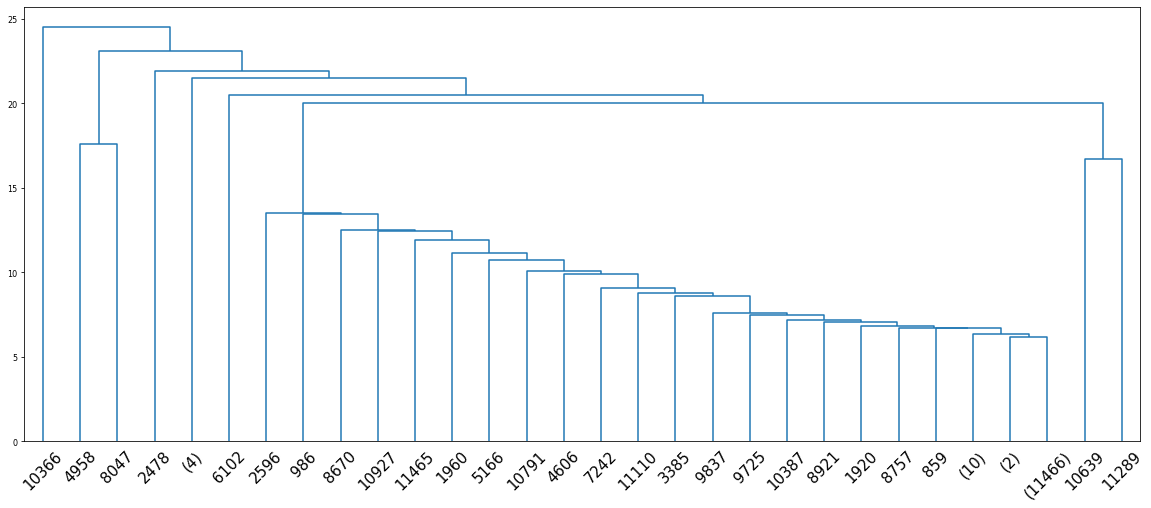

In [63]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[0], metric=metric[11])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

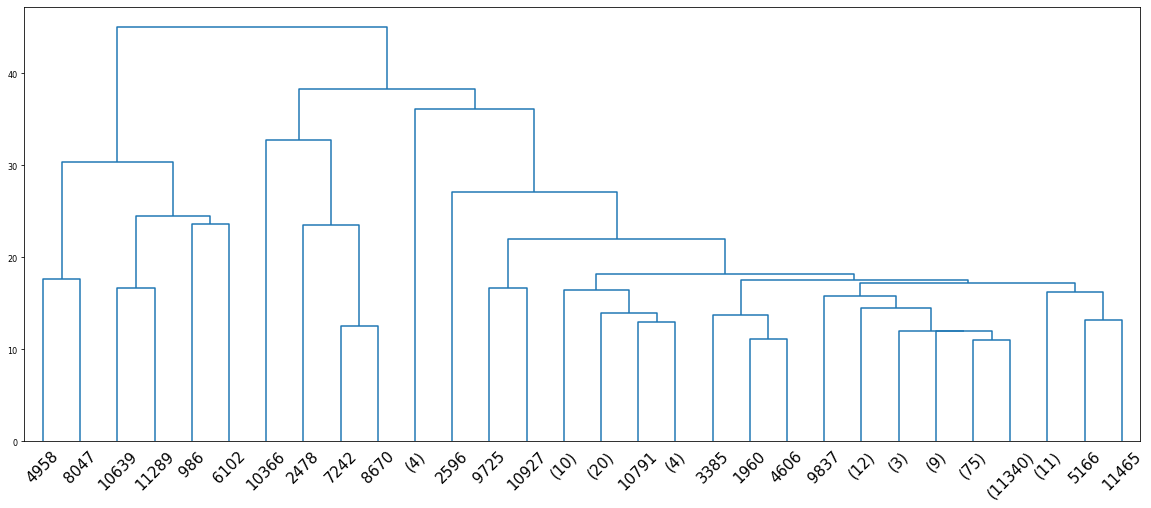

In [64]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[1], metric=metric[11])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

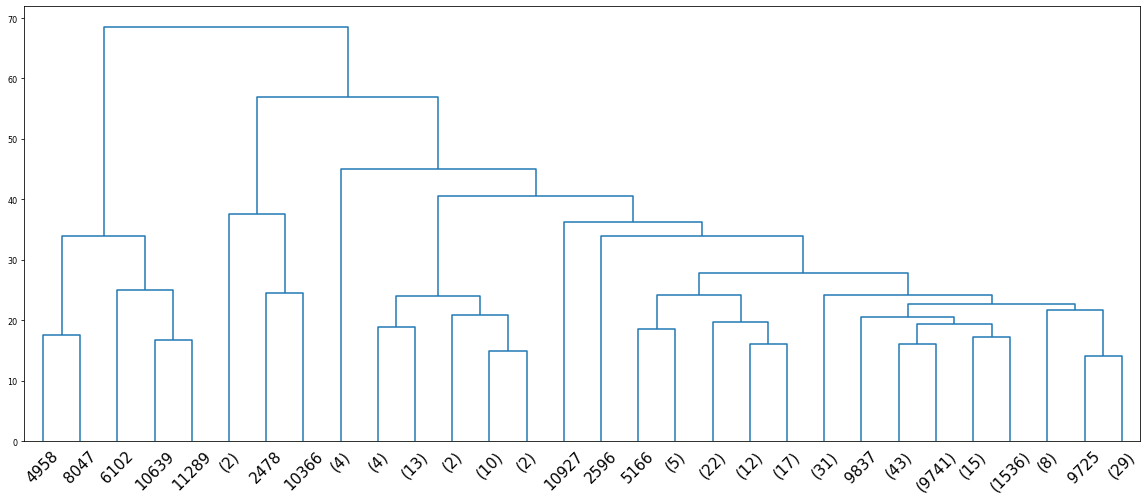

In [65]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method=method[2], metric=metric[11])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

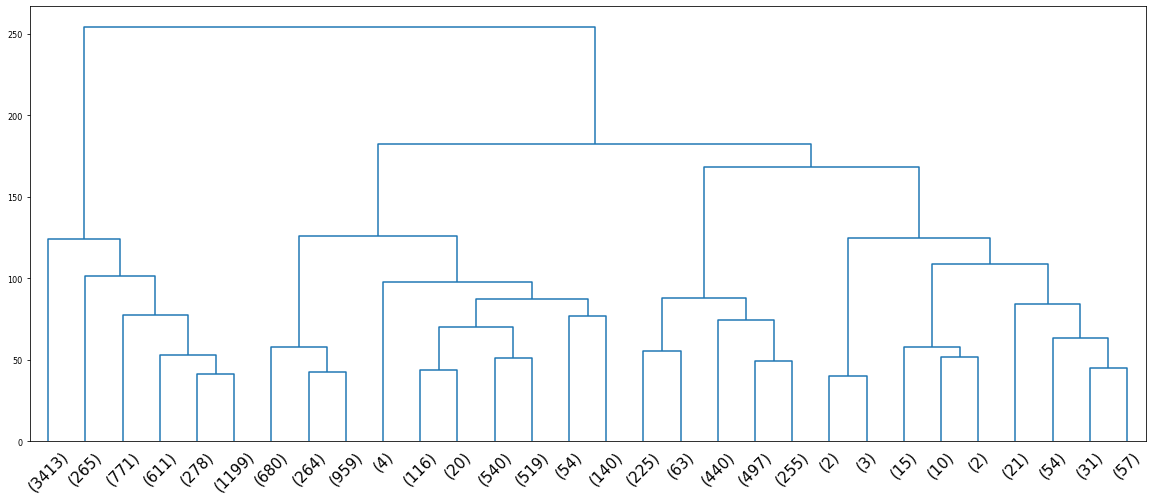

In [18]:
data_dist = pdist(X, metric=metric[11])
data_link = linkage(data_dist, method='ward', metric=metric[11])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### rogerstanimoto

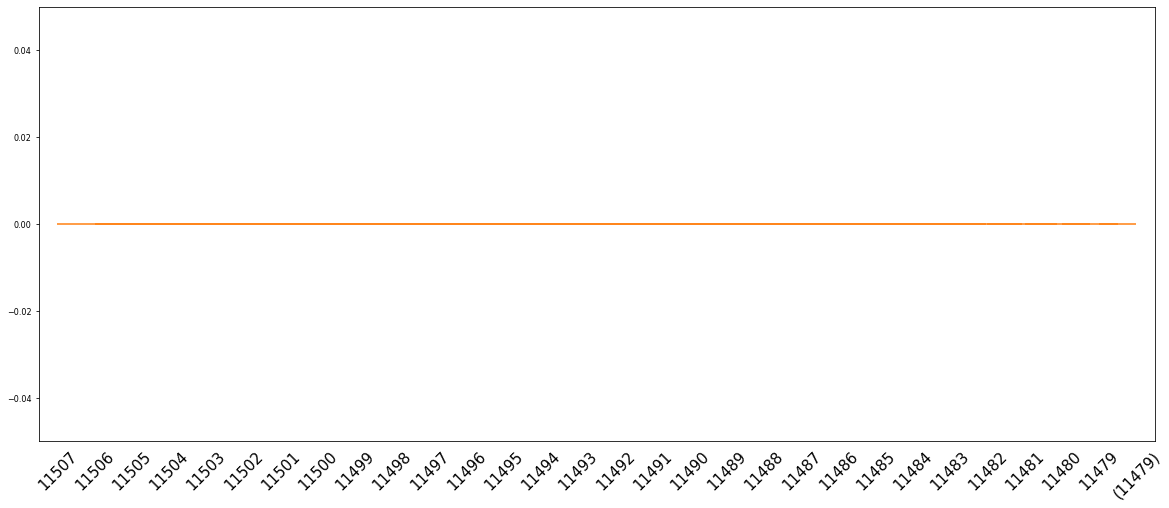

In [66]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[0], metric=metric[12])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

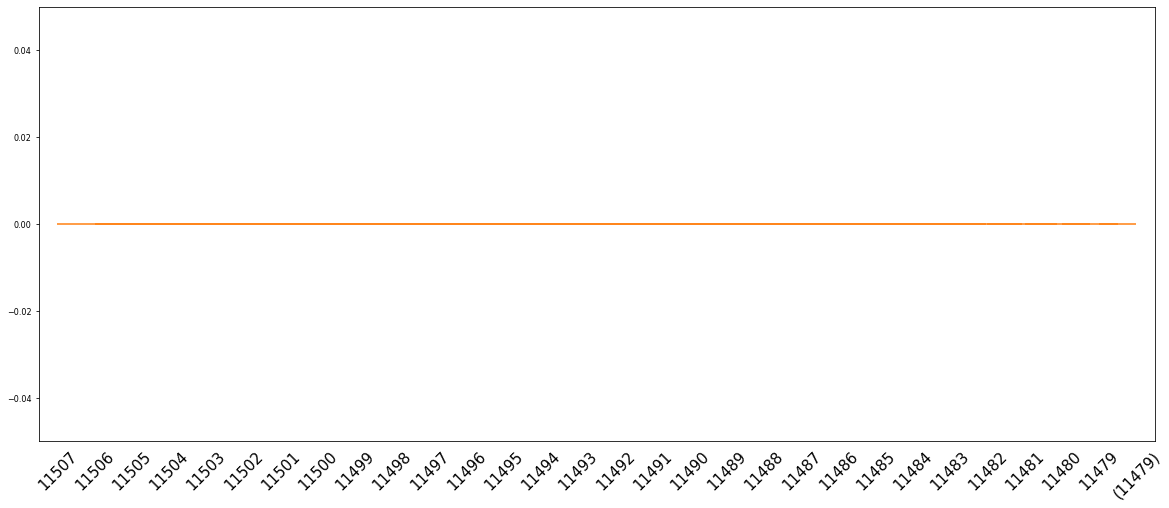

In [67]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[1], metric=metric[12])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

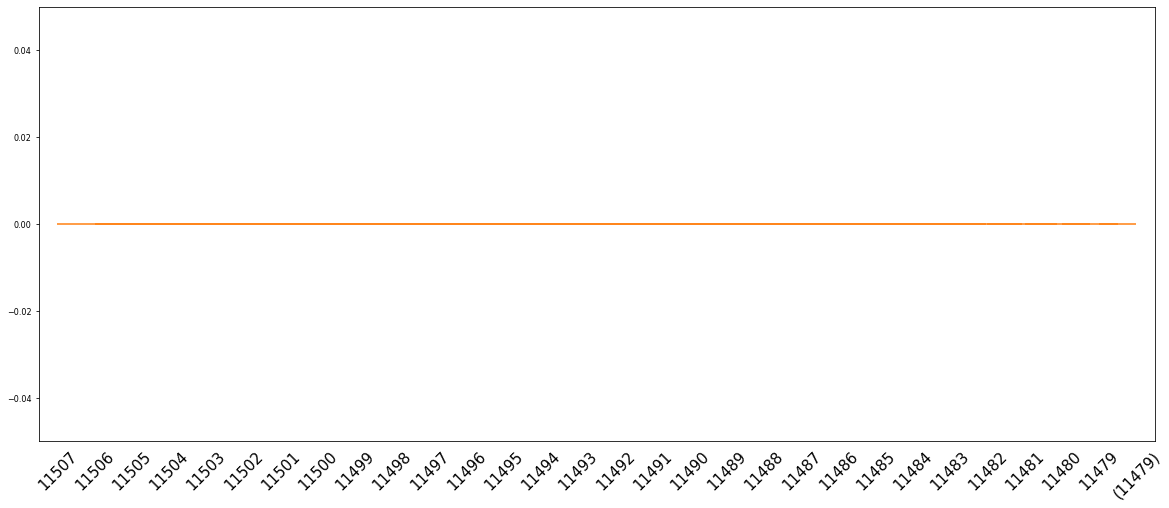

In [68]:
data_dist = pdist(X, metric=metric[12])
data_link = linkage(data_dist, method=method[2], metric=metric[12])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### russellrao

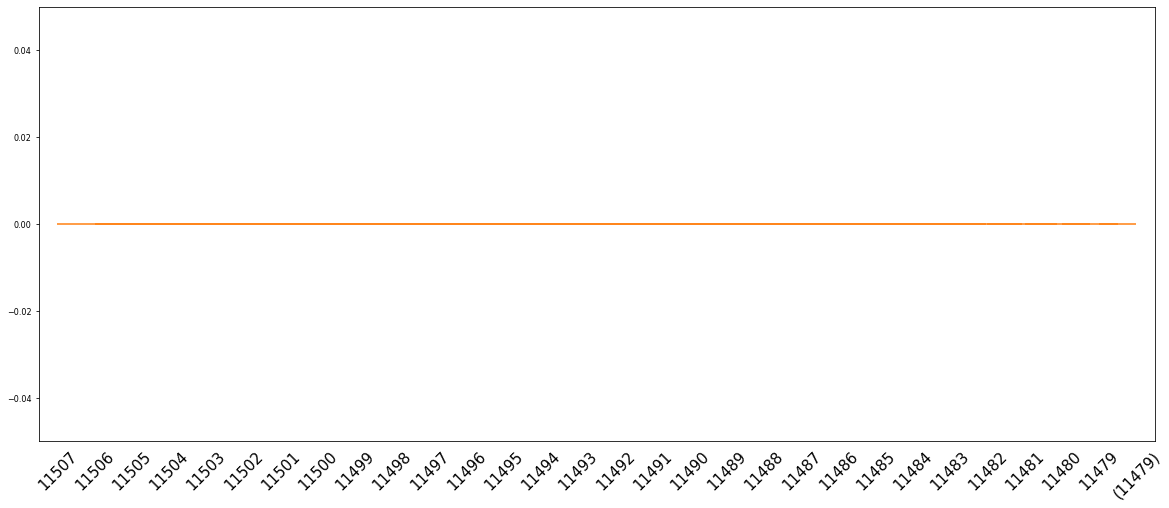

In [69]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[0], metric=metric[13])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

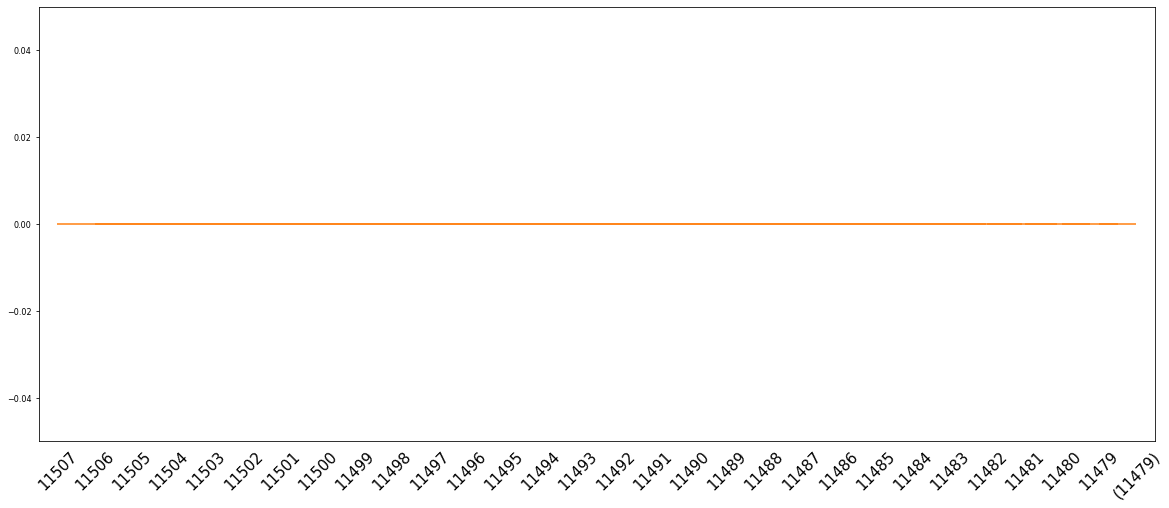

In [70]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[1], metric=metric[13])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

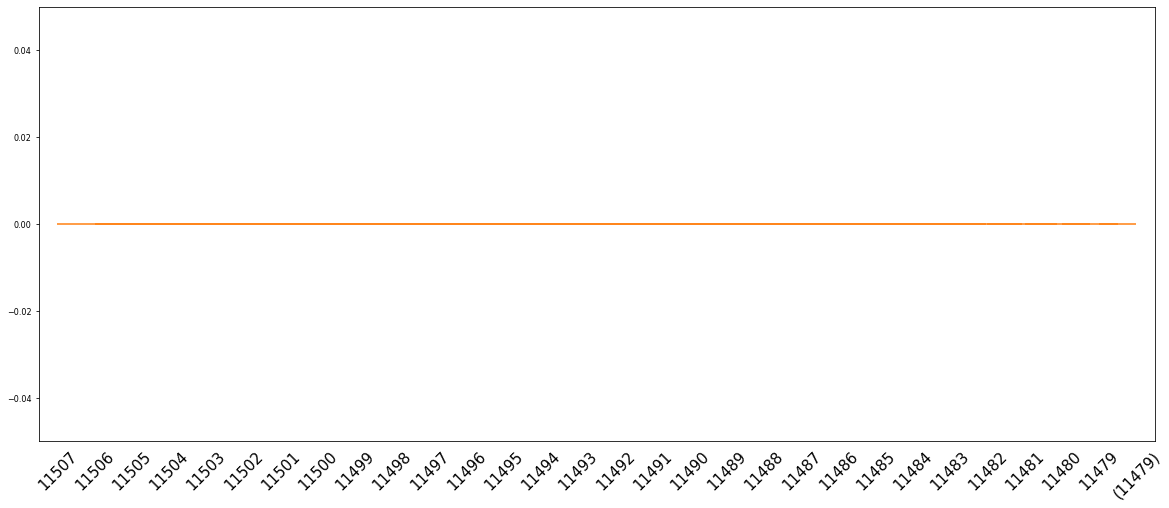

In [71]:
data_dist = pdist(X, metric=metric[13])
data_link = linkage(data_dist, method=method[2], metric=metric[13])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### seuclidean

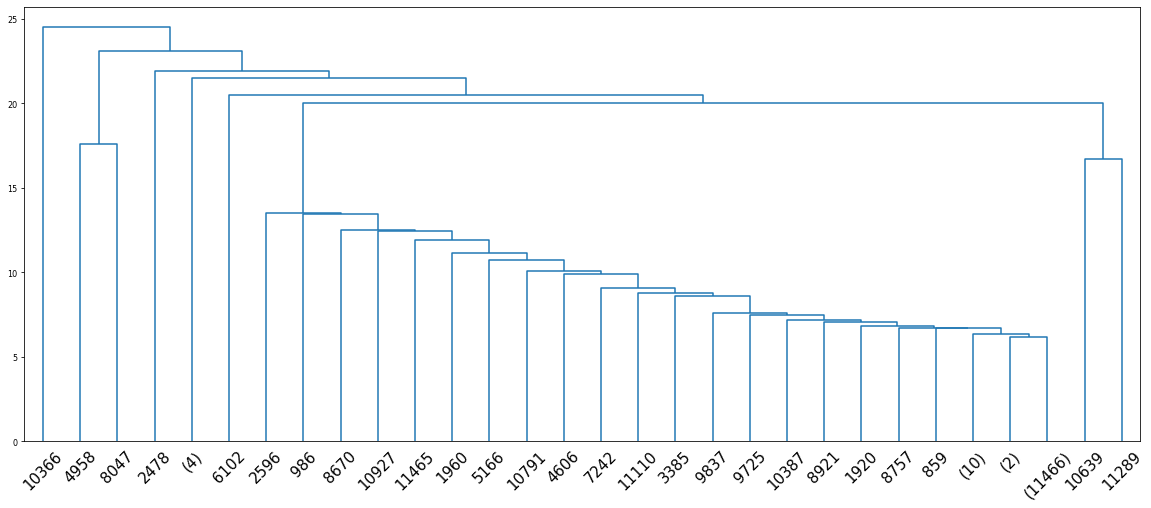

In [72]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[0], metric=metric[14])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

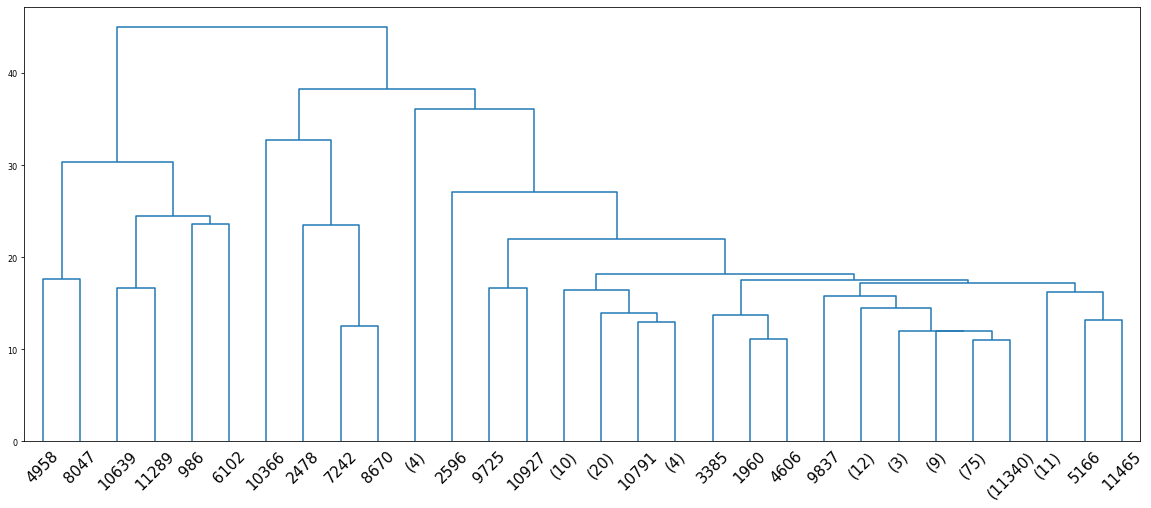

In [73]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[1], metric=metric[14])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

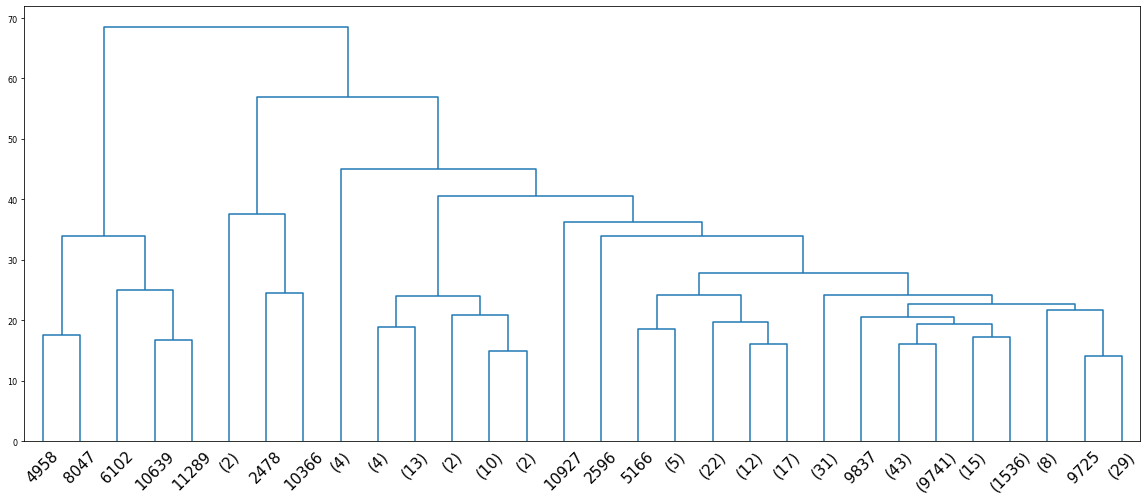

In [74]:
data_dist = pdist(X, metric=metric[14])
data_link = linkage(data_dist, method=method[2], metric=metric[14])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### sokalmichener

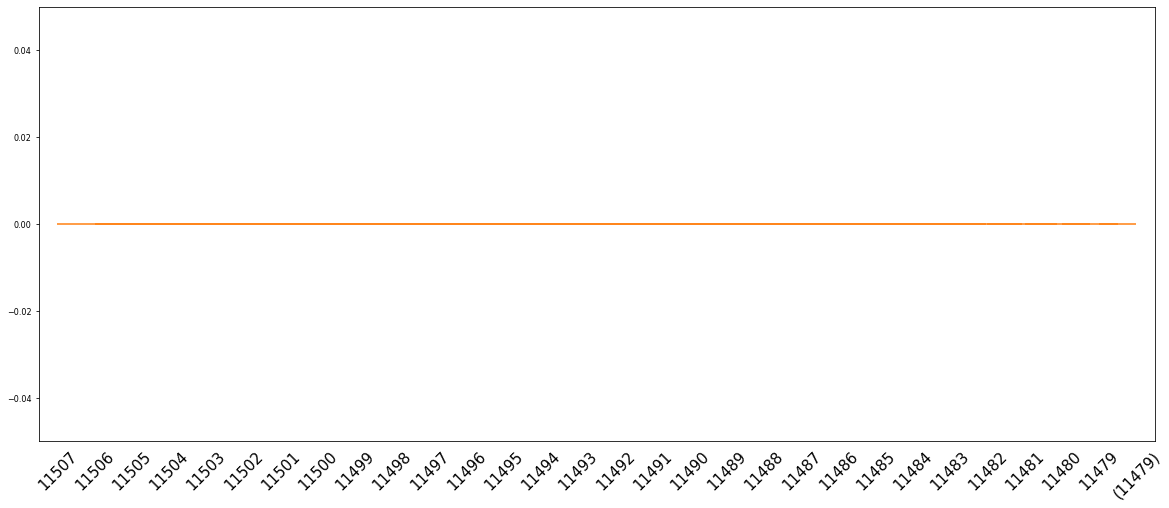

In [75]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[0], metric=metric[15])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

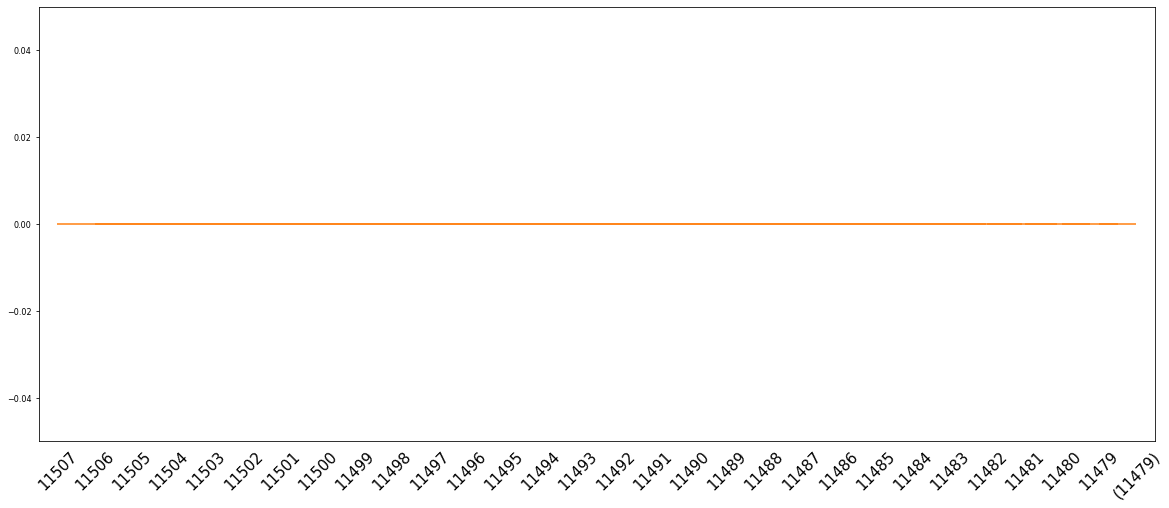

In [76]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[1], metric=metric[15])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

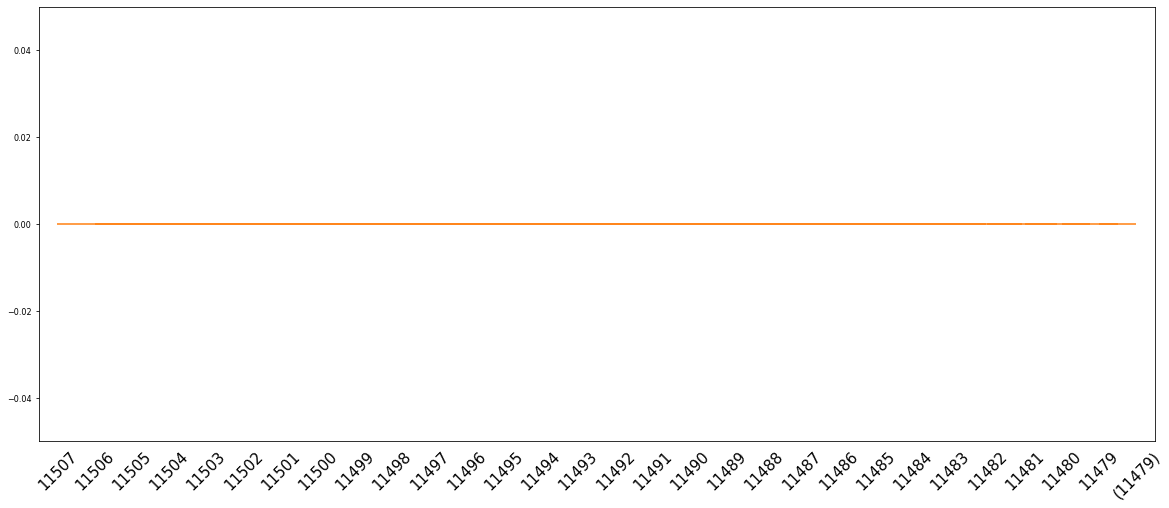

In [77]:
data_dist = pdist(X, metric=metric[15])
data_link = linkage(data_dist, method=method[2], metric=metric[15])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### sokalsneath

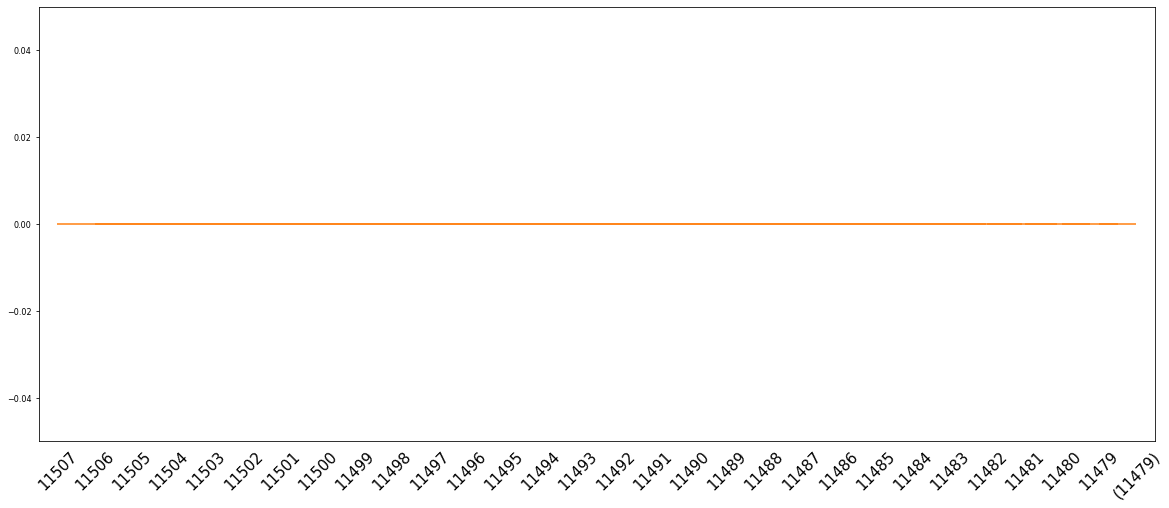

In [78]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[0], metric=metric[16])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

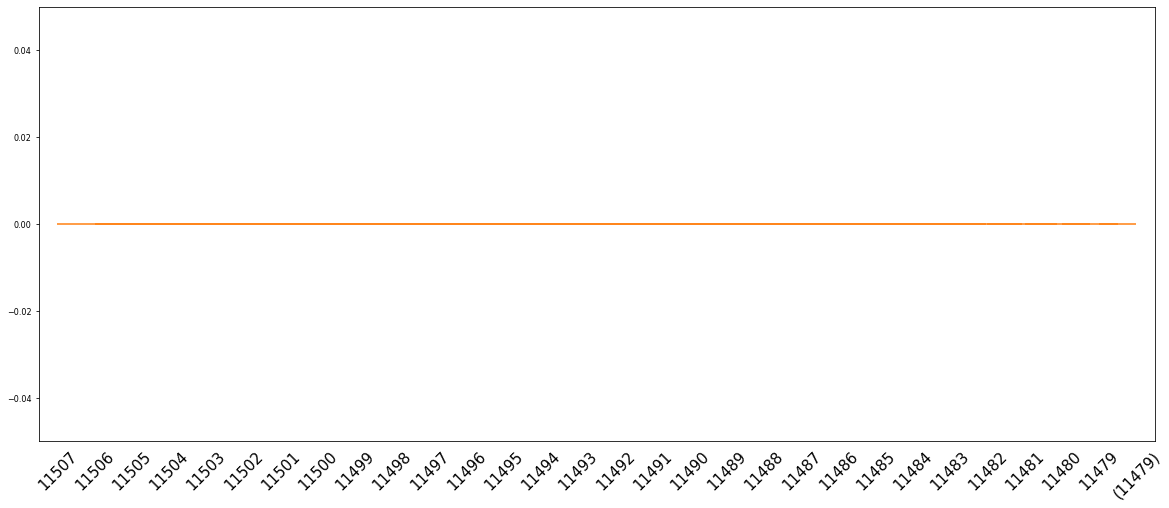

In [79]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[1], metric=metric[16])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

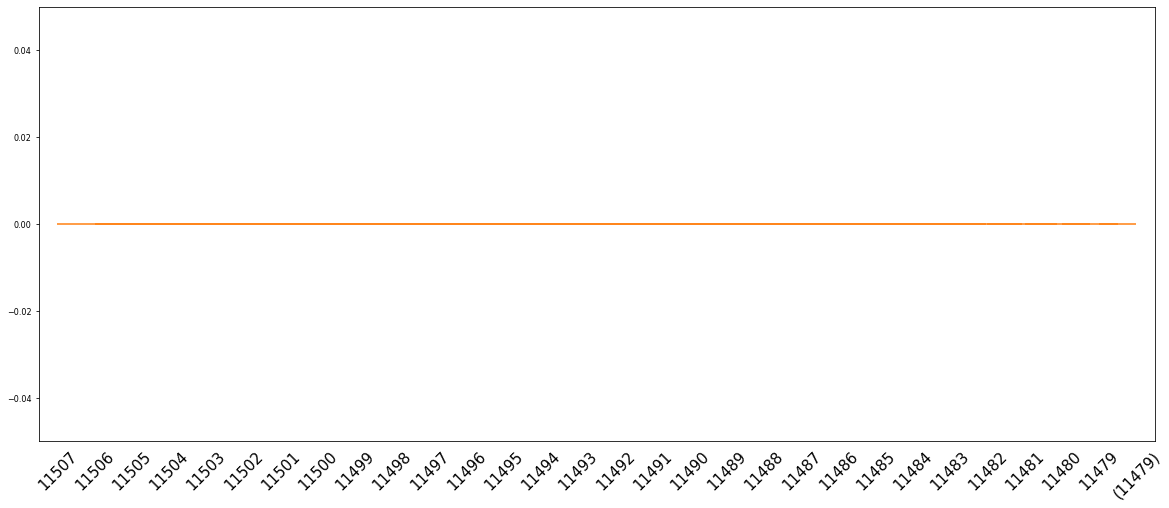

In [80]:
data_dist = pdist(X, metric=metric[16])
data_link = linkage(data_dist, method=method[2], metric=metric[16])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### sqeuclidean

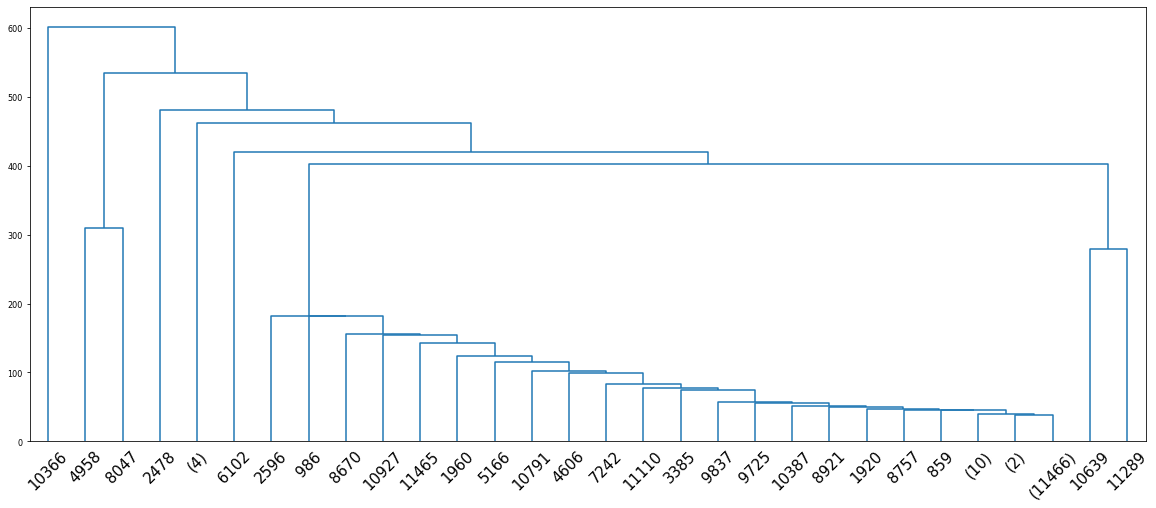

In [81]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[0], metric=metric[17])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

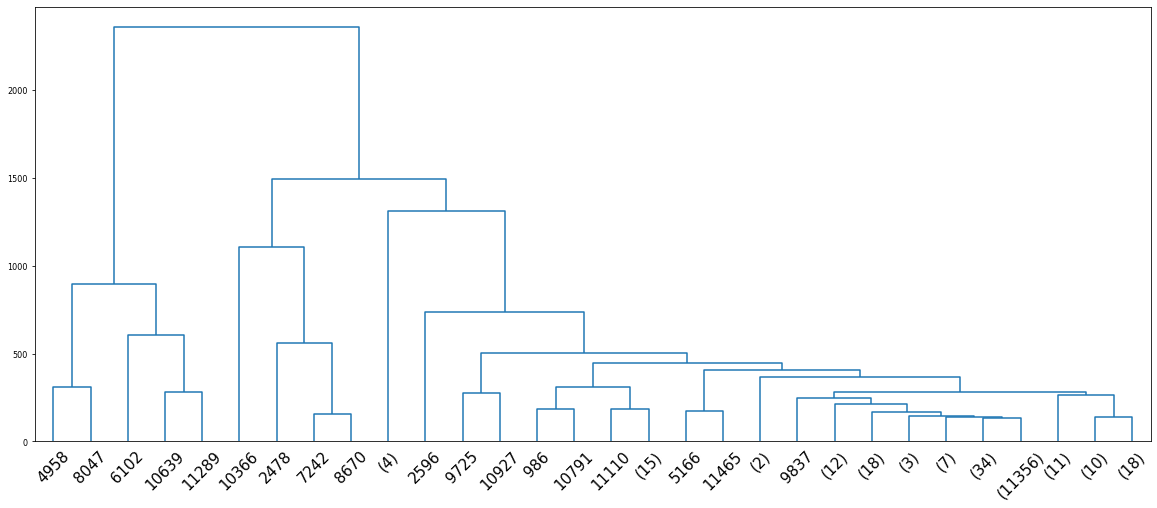

In [82]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[1], metric=metric[17])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

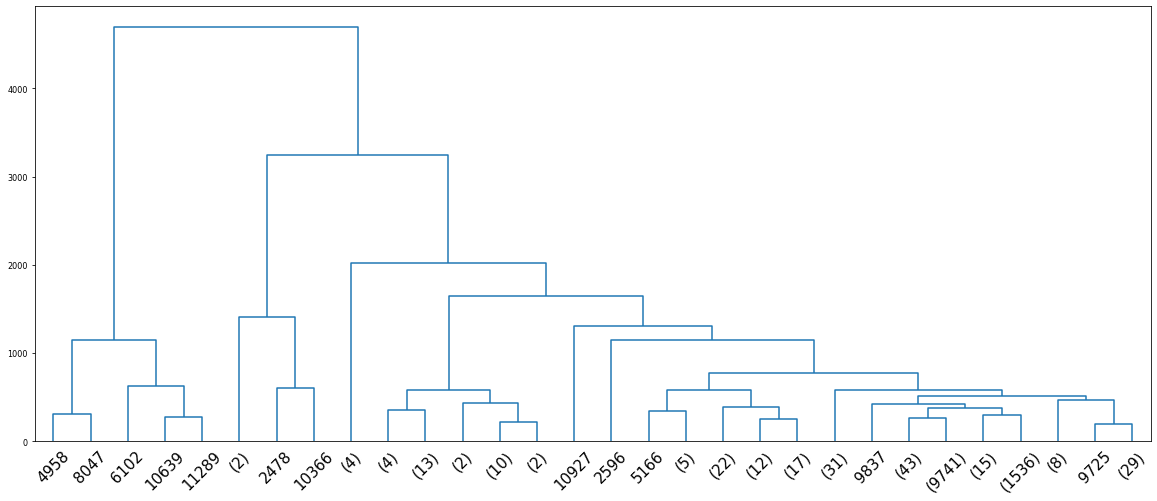

In [83]:
data_dist = pdist(X, metric=metric[17])
data_link = linkage(data_dist, method=method[2], metric=metric[17])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### yule

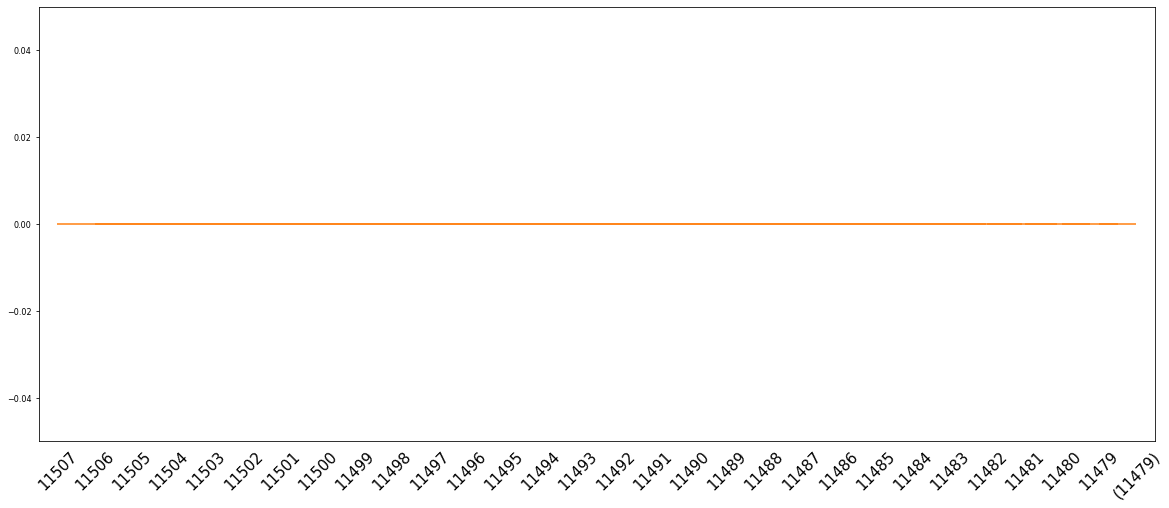

In [84]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[0], metric=metric[18])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

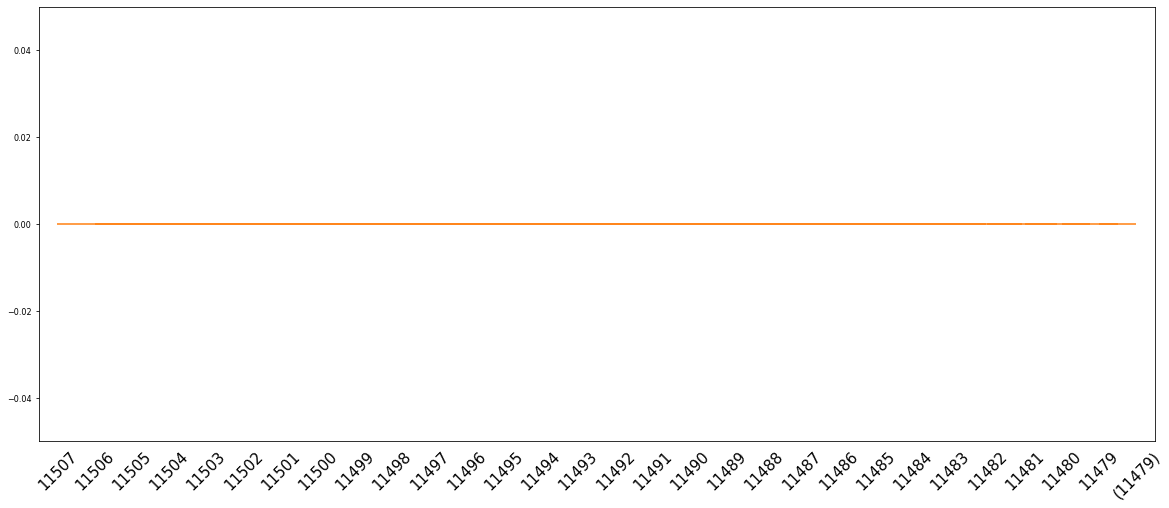

In [85]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[1], metric=metric[18])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

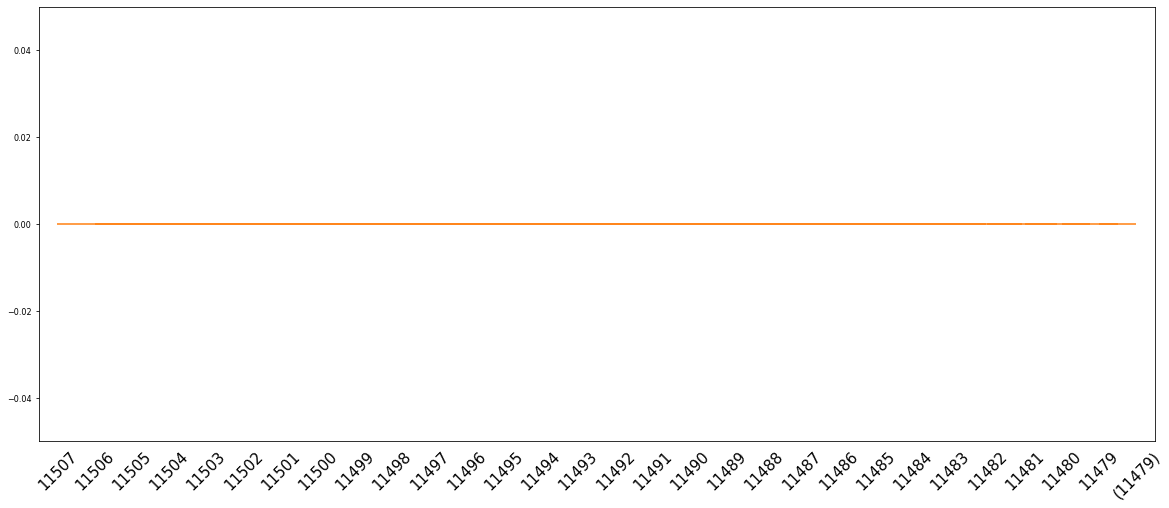

In [86]:
data_dist = pdist(X, metric=metric[18])
data_link = linkage(data_dist, method=method[2], metric=metric[18])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### cosine

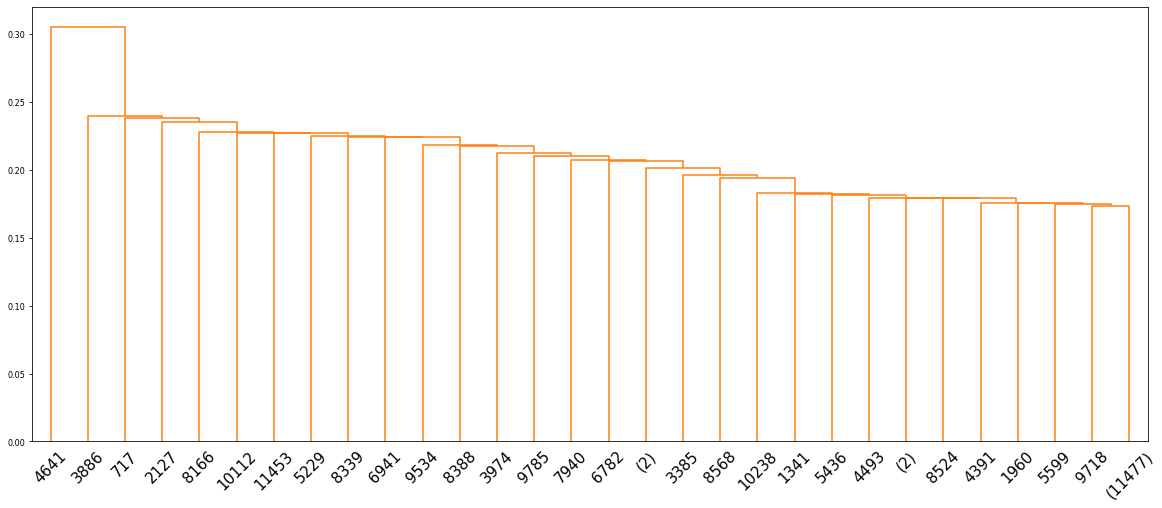

In [87]:
data_dist = pdist(X, metric=metric[19])
data_link = linkage(data_dist, method=method[0], metric=metric[19])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

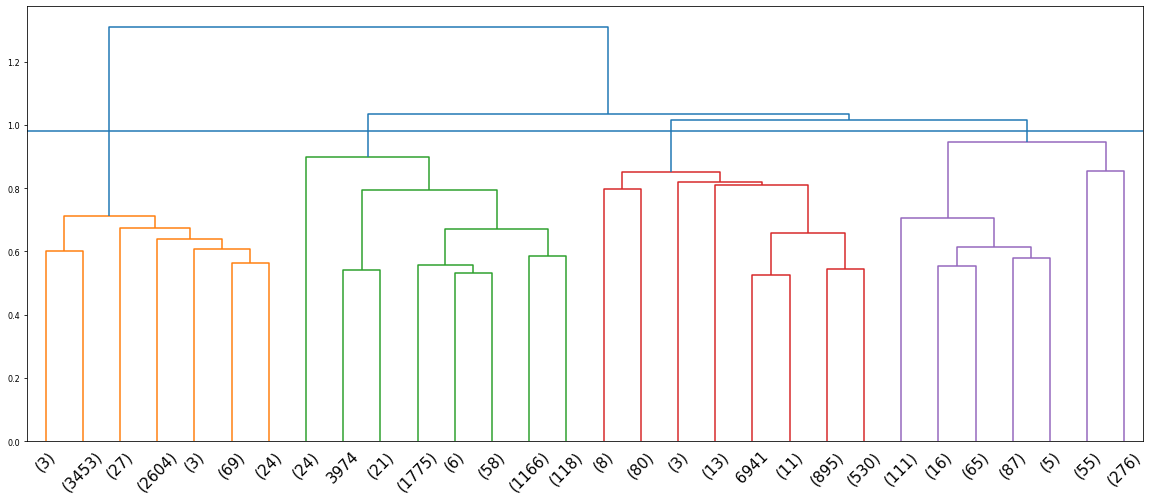

In [18]:
data_dist = pdist(X, metric=metric[19])
data_link = linkage(data_dist, method=method[1], metric=metric[19])


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.axhline(y=0.98)

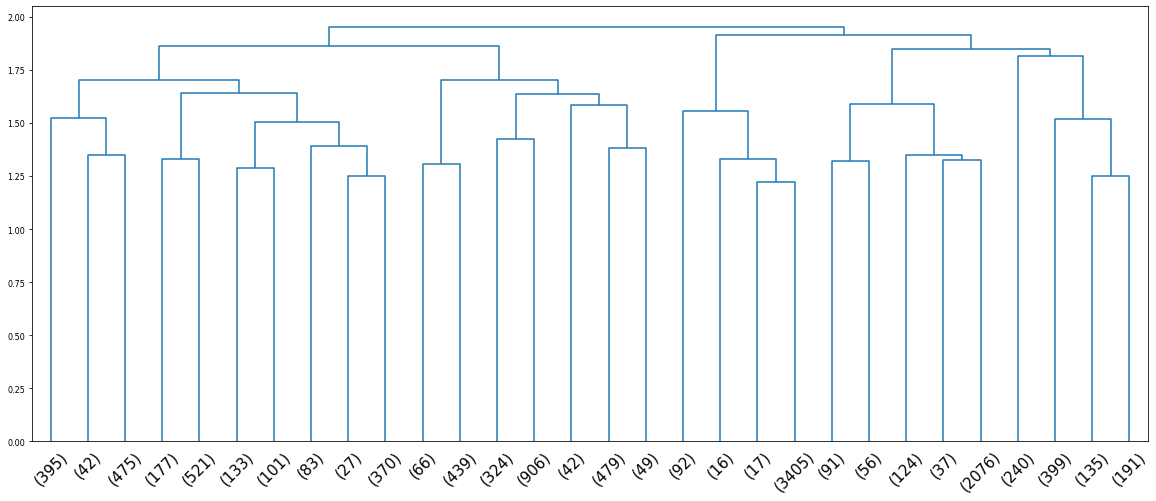

In [89]:
data_dist = pdist(X, metric=metric[19])
data_link = linkage(data_dist, method=method[2], metric=metric[19])


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

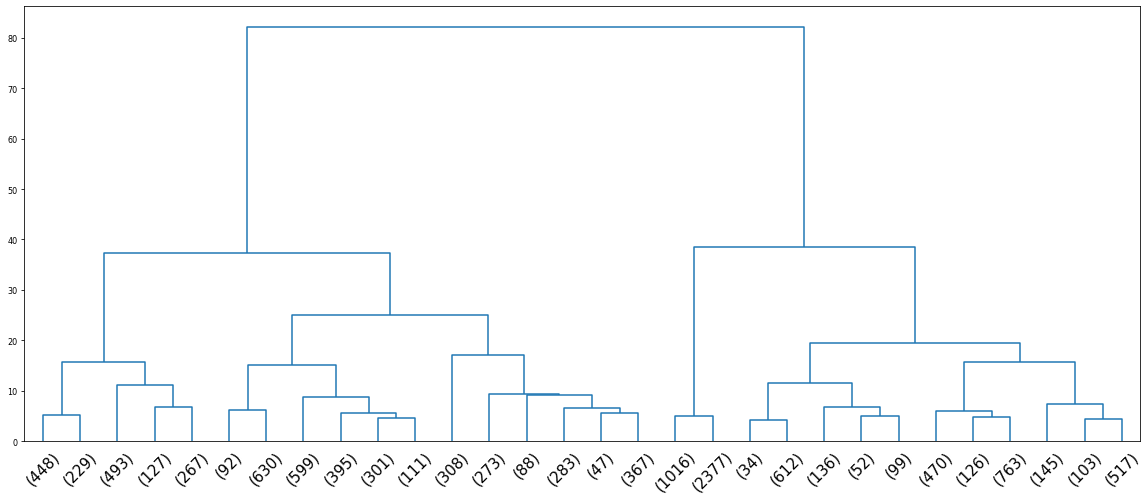

In [16]:
data_dist = pdist(X, metric=metric[19])
data_link = linkage(data_dist, method='ward', metric=metric[19])


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

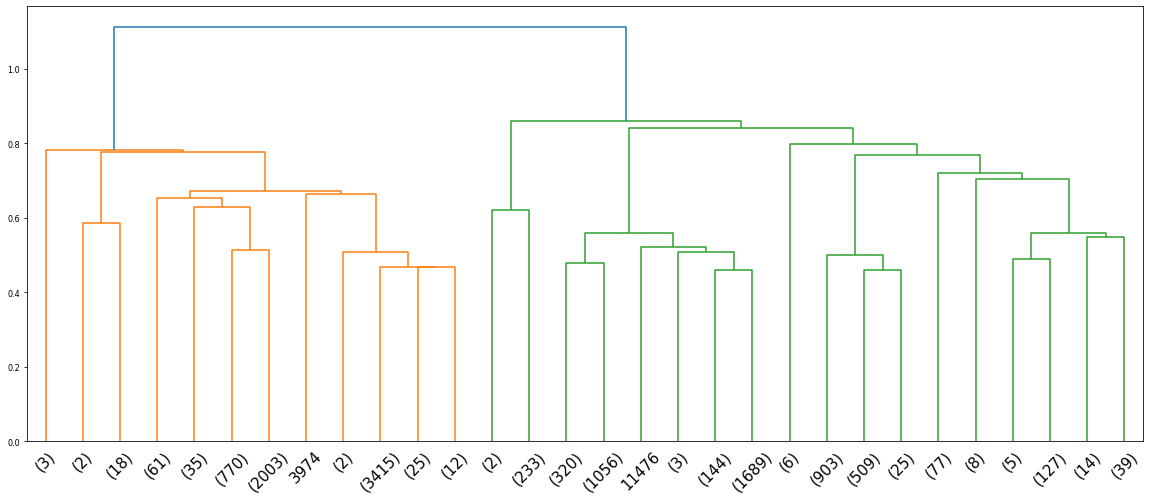

In [17]:
data_dist = pdist(X, metric=metric[19])
data_link = linkage(data_dist, method='centroid', metric=metric[19])


fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

##### euclidean

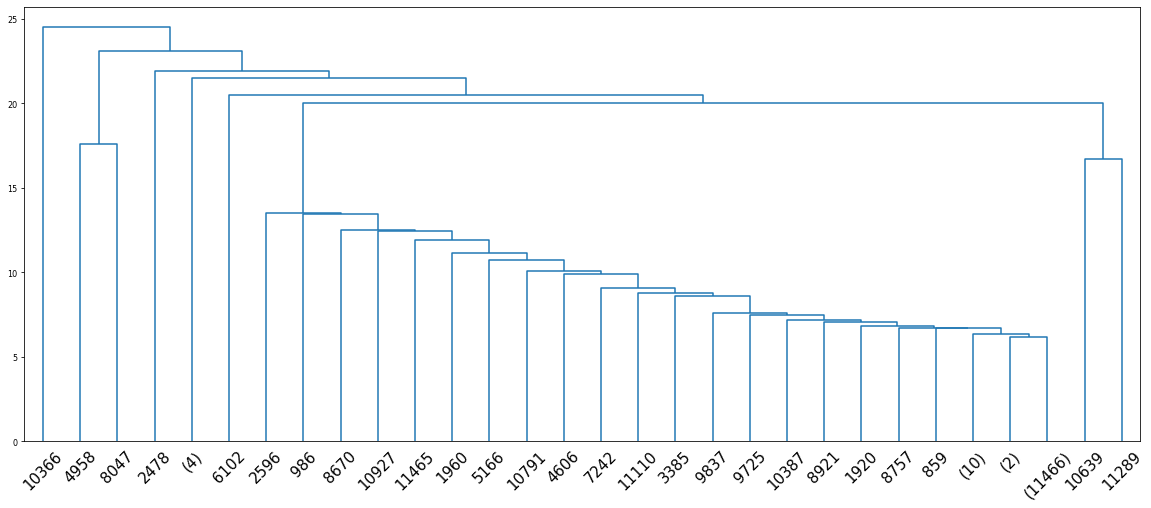

In [90]:
data_dist = pdist(X, metric=metric[20])
data_link = linkage(data_dist, method=method[0], metric=metric[20])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

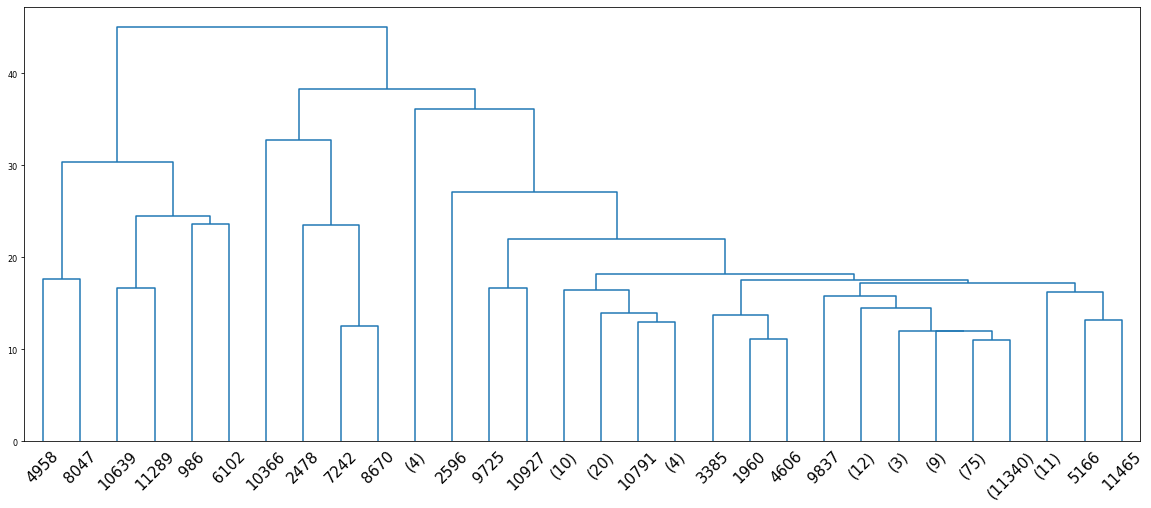

In [91]:
data_dist = pdist(X, metric=metric[20])
data_link = linkage(data_dist, method=method[1], metric=metric[20])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

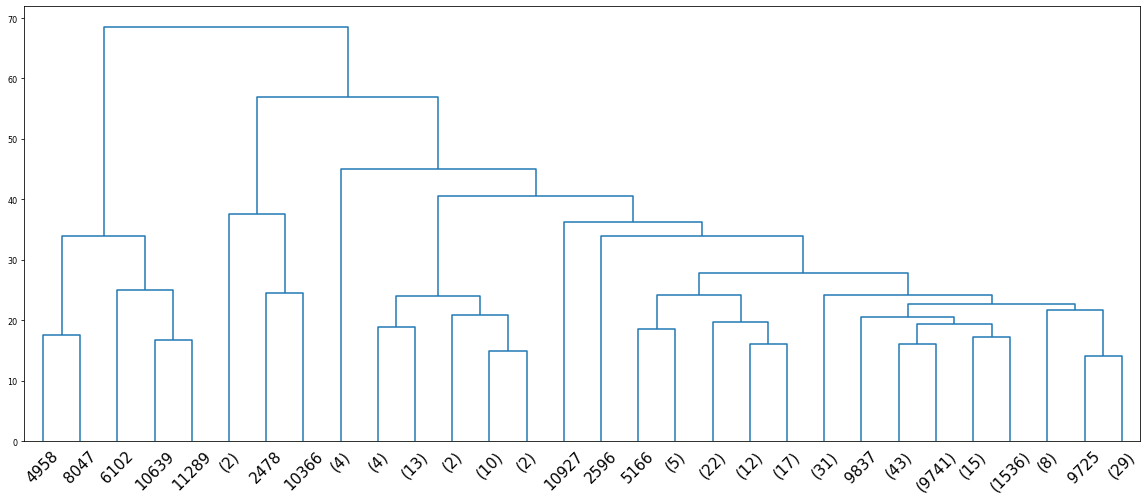

In [92]:
data_dist = pdist(X, metric=metric[20])
data_link = linkage(data_dist, method=method[2], metric=metric[20])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

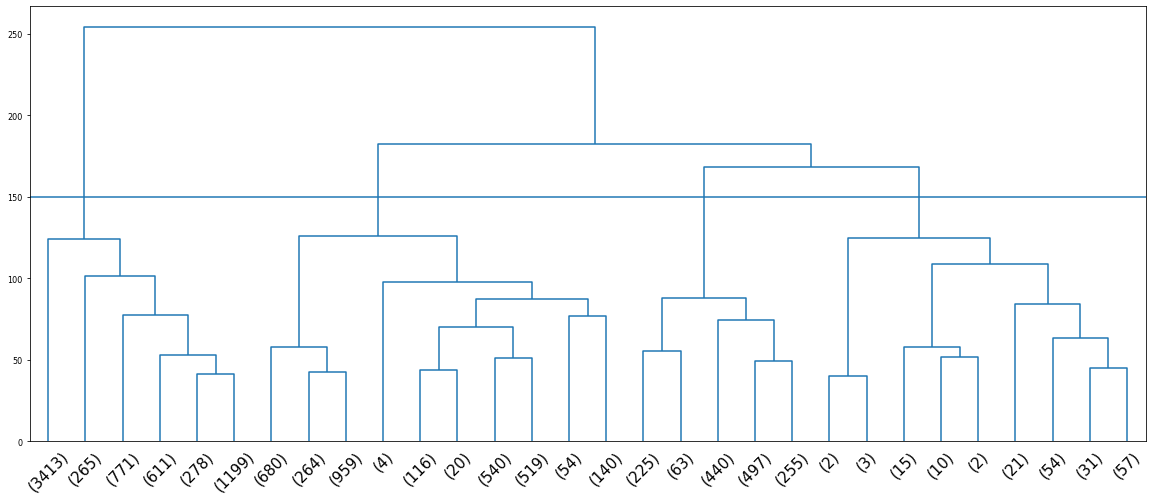

In [20]:
data_dist = pdist(X, metric=metric[20])
data_link = linkage(data_dist, method='ward', metric=metric[20])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)
ax.axhline(y=150)

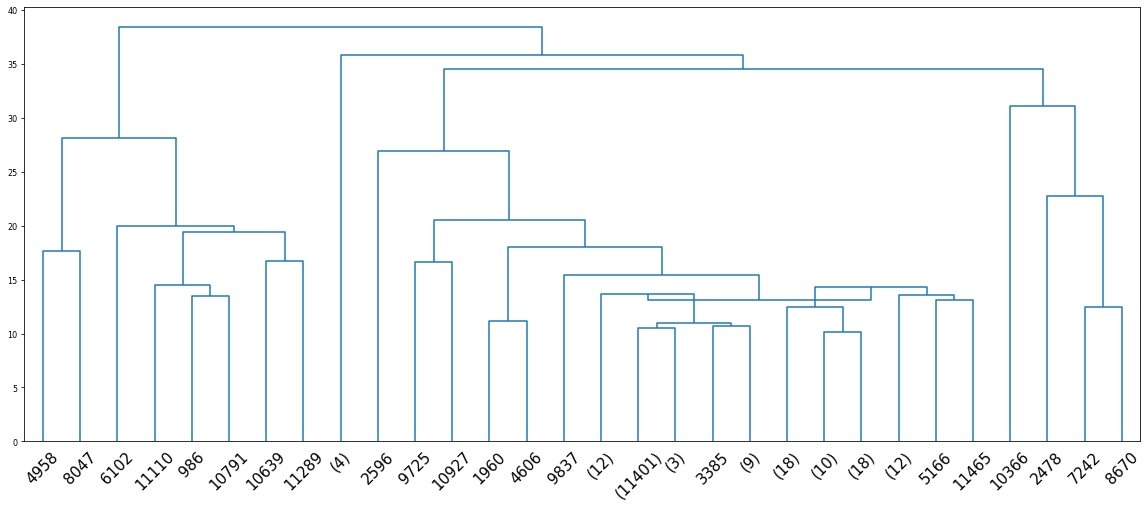

In [16]:
data_dist = pdist(X, metric=metric[20])
data_link = linkage(data_dist, method='centroid', metric=metric[20])

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1, 1, 1)
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=8)

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
linkage = ['ward', 'complete', 'average', 'single']
affinity = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']

##### AgglomerativeClustering with cosine as affinity and average as linkage

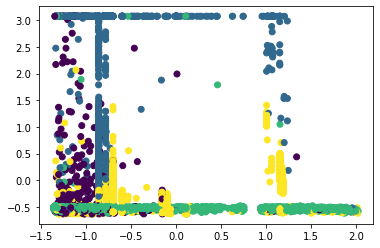

In [20]:
res_cluster = AgglomerativeClustering(n_clusters=4, affinity=affinity[4], linkage=linkage[2])
res_cluster.fit_predict(X)
plt.scatter(X[:,0],X[:,1], c=res_cluster.labels_)

In [21]:
print('Silhouette %s' % silhouette_score(X, res_cluster.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, res_cluster.labels_))

Silhouette 0.37861548658307226
Separation 1.9921202918477394


### Plot Cluster Results

[[-0.95374165 -0.13647862  0.47657723  0.58224973  2.03447891  0.28451791
   0.16158196  1.14159757  1.60353867  1.73709484  0.32617774  0.93282032
  -0.5985205   0.01970887  0.04288343 -0.46963232]
 [-0.68375027  2.0345735   1.06621564  0.77524249  0.42818196 -0.78388999
  -0.27925067 -0.02811869 -0.06481561 -0.16160431  0.56208349  0.37898688
   0.96567362 -0.06580986 -0.24860975  0.67670531]
 [-0.3648946  -0.50908478 -0.02748237 -0.15484172  0.20013848  1.16301275
   0.47143972 -0.08163234 -0.10782728 -0.24578343  0.15335359  0.34182324
   1.03963095  0.66127541  1.26395011  1.12684753]
 [ 0.45229844 -0.23258188 -0.29905251 -0.17176757 -0.41165644 -0.42901366
  -0.18810288 -0.06470301 -0.08807873 -0.00653298 -0.25113173 -0.36243589
  -0.71399053 -0.32448483 -0.59012188 -0.69949196]]


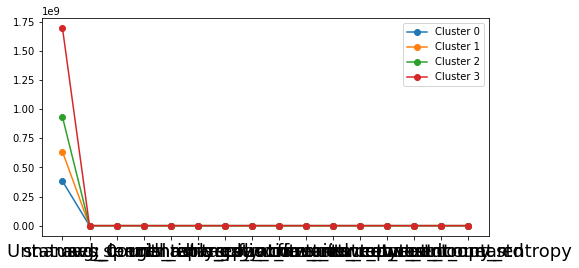

In [22]:
y_predict = res_cluster.fit_predict(X)
clf = NearestCentroid()
clf.fit(X, y_predict)
print(clf.centroids_)

centers = scaler.inverse_transform(clf.centroids_)
plot_parallel_coordinates_clusters(df, centers)

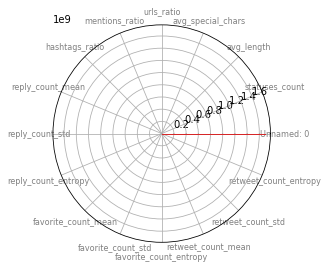

In [23]:
plot_radar_clusters(df, centers)

#### Distribution of CategoricalFeatures per Cluster

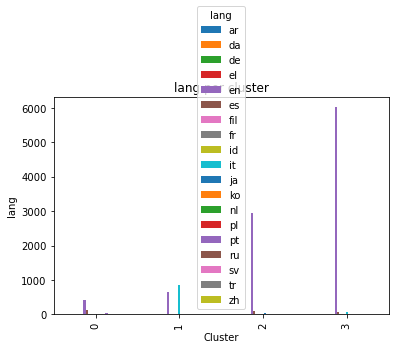

In [24]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "lang")

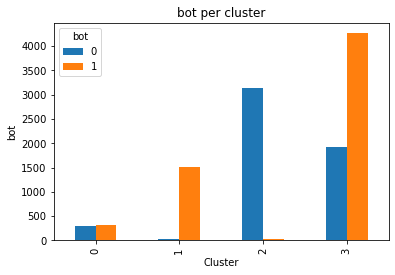

In [25]:
categorical_hist_clusters(df_cat, res_cluster.labels_, "bot")

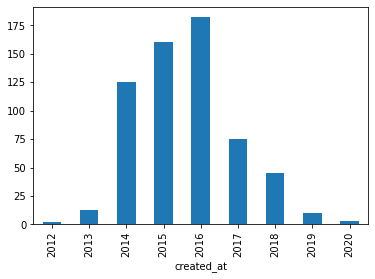

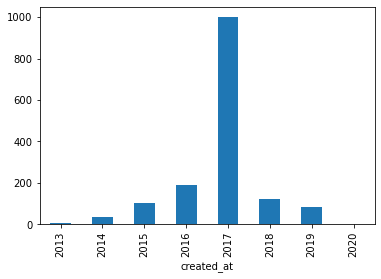

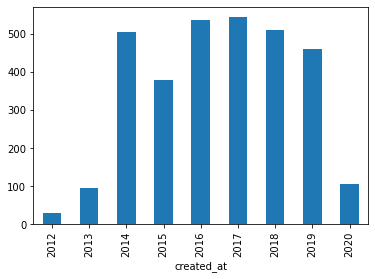

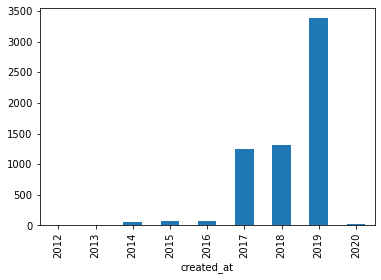

In [26]:
plot_date_feature_clusters(df, res_cluster.labels_, 4)

#### Distribution of Numerical Features per Cluster

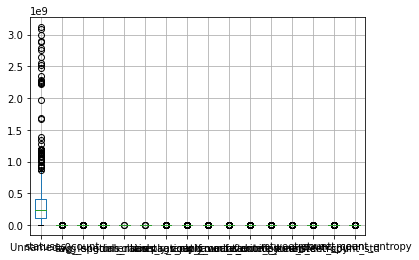

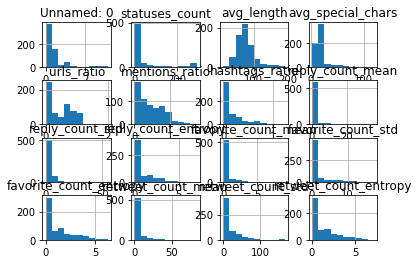

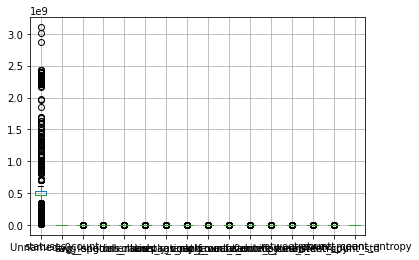

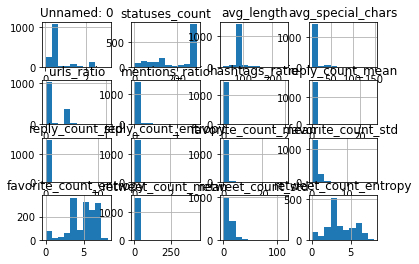

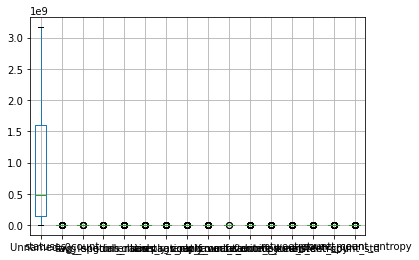

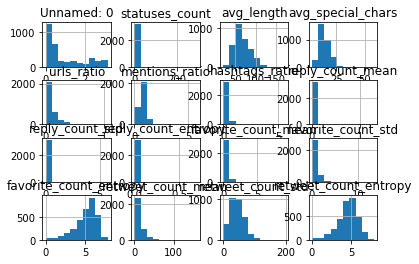

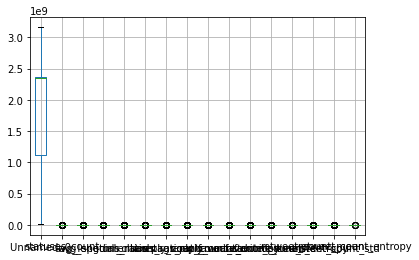

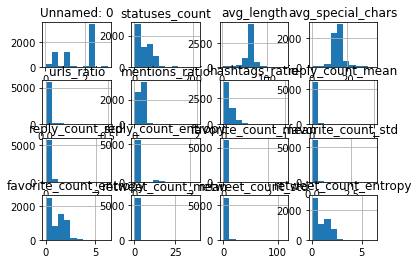

In [27]:
plot_numerical_features_clusters(df, res_cluster.labels_, 4)

Unnamed: 0 - statuses_count


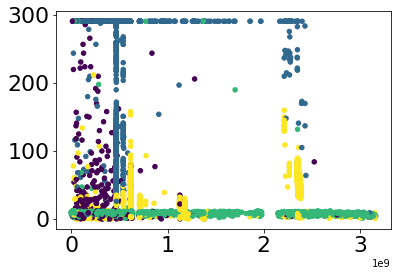

Unnamed: 0 - avg_length


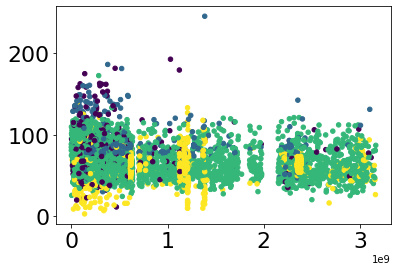

Unnamed: 0 - avg_special_chars


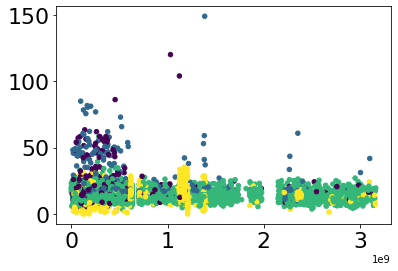

Unnamed: 0 - urls_ratio


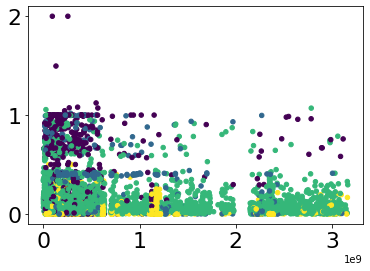

Unnamed: 0 - mentions_ratio


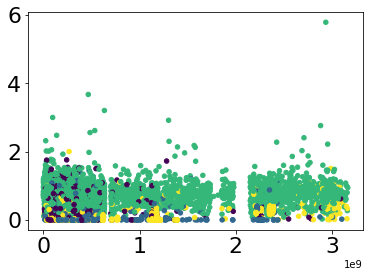

Unnamed: 0 - hashtags_ratio


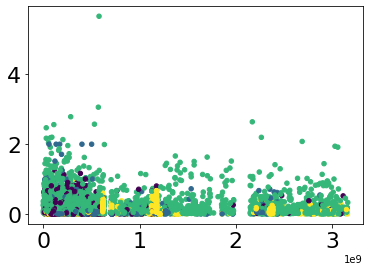

Unnamed: 0 - reply_count_mean


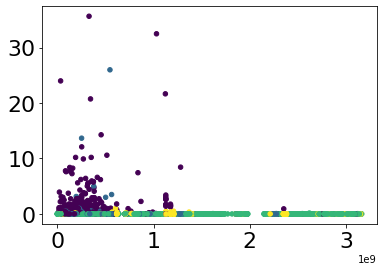

Unnamed: 0 - reply_count_std


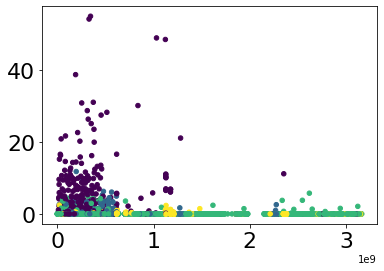

Unnamed: 0 - reply_count_entropy


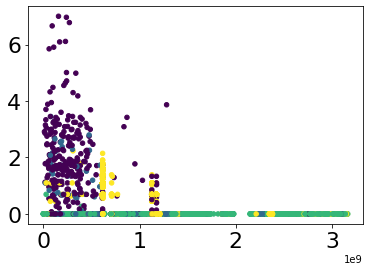

Unnamed: 0 - favorite_count_mean


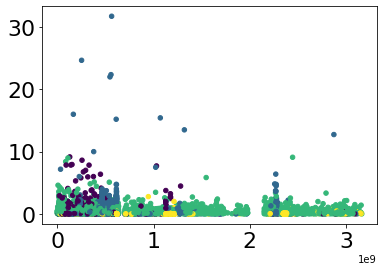

Unnamed: 0 - favorite_count_std


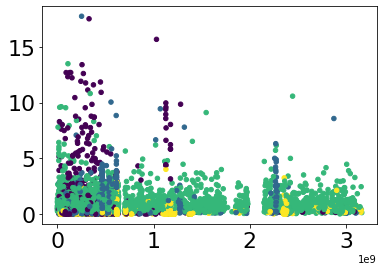

Unnamed: 0 - favorite_count_entropy


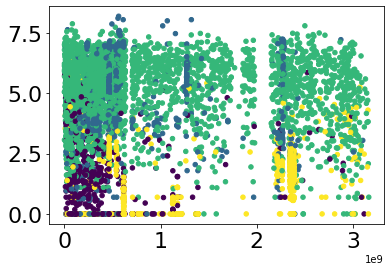

Unnamed: 0 - retweet_count_mean


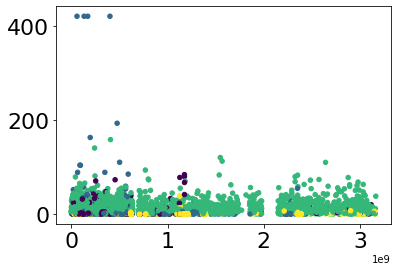

Unnamed: 0 - retweet_count_std


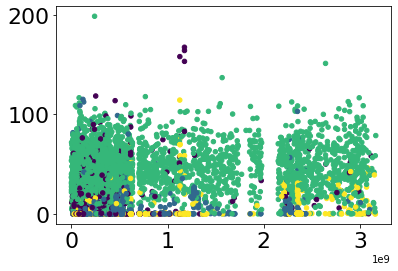

Unnamed: 0 - retweet_count_entropy


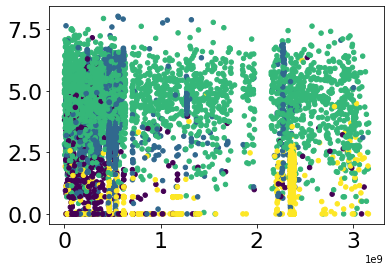

statuses_count - avg_length


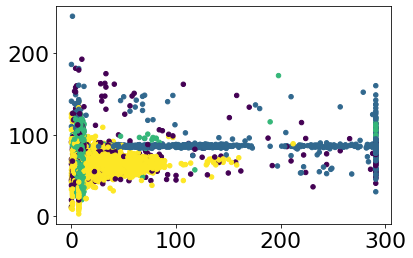

statuses_count - avg_special_chars


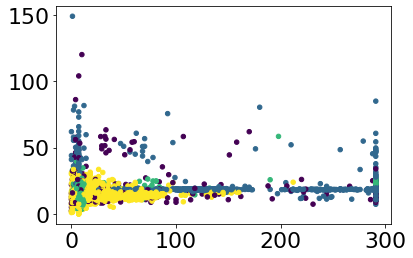

statuses_count - urls_ratio


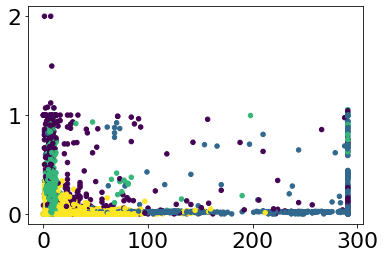

statuses_count - mentions_ratio


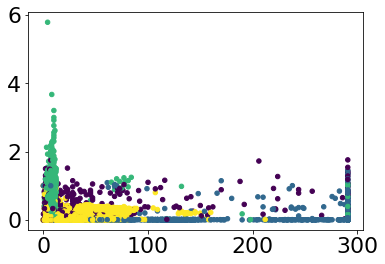

statuses_count - hashtags_ratio


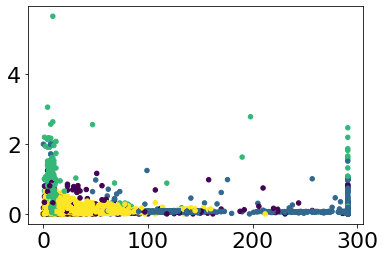

statuses_count - reply_count_mean


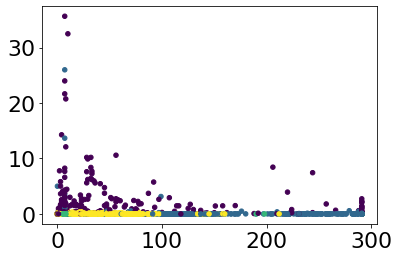

statuses_count - reply_count_std


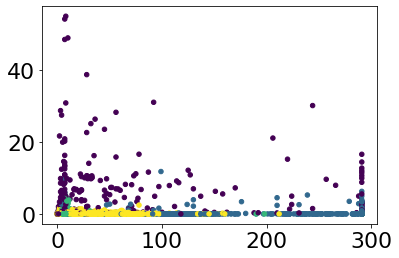

statuses_count - reply_count_entropy


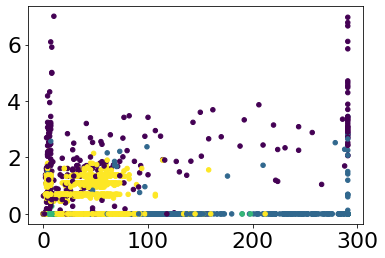

statuses_count - favorite_count_mean


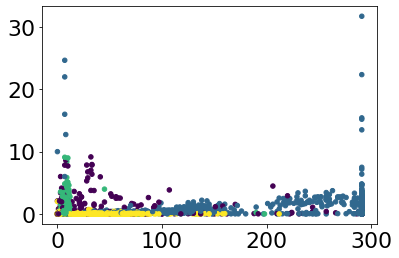

statuses_count - favorite_count_std


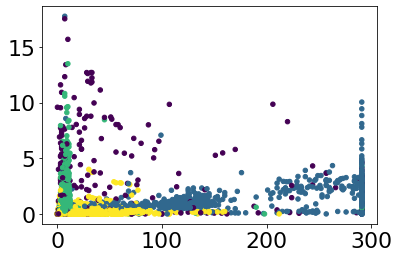

statuses_count - favorite_count_entropy


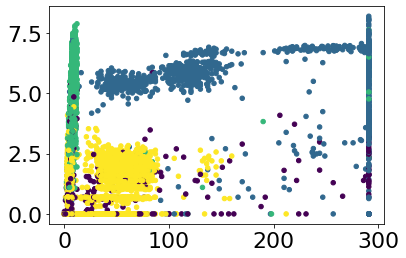

statuses_count - retweet_count_mean


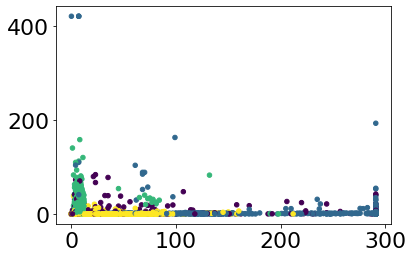

statuses_count - retweet_count_std


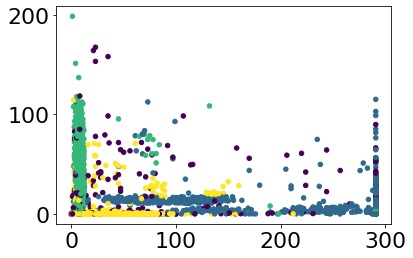

statuses_count - retweet_count_entropy


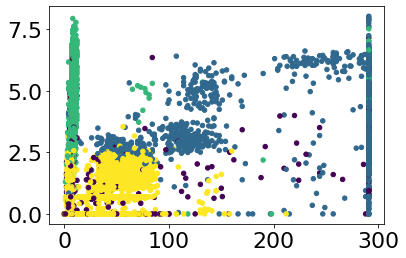

avg_length - avg_special_chars


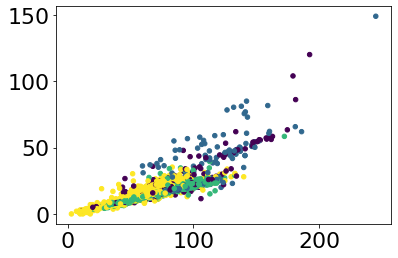

avg_length - urls_ratio


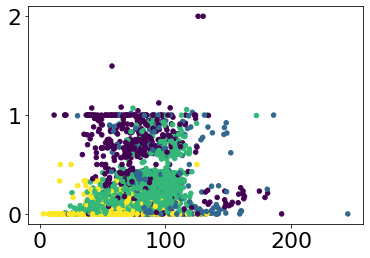

avg_length - mentions_ratio


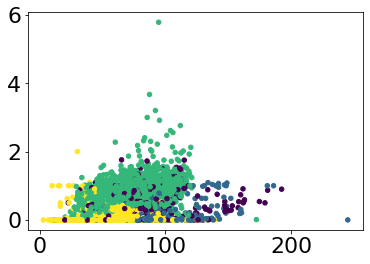

avg_length - hashtags_ratio


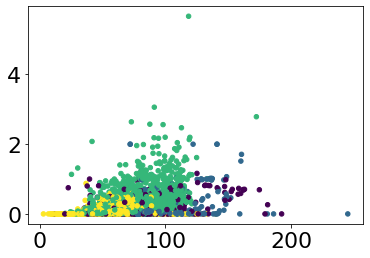

avg_length - reply_count_mean


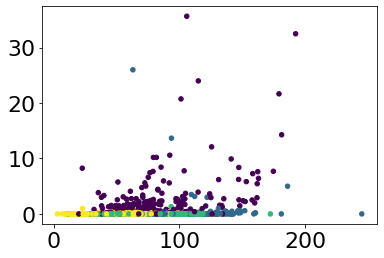

avg_length - reply_count_std


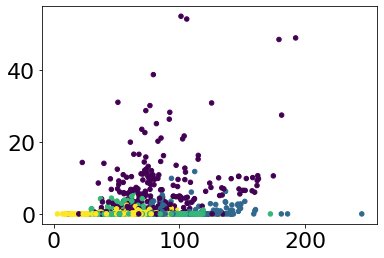

avg_length - reply_count_entropy


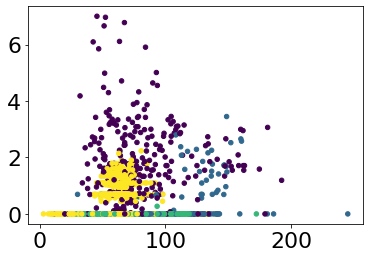

avg_length - favorite_count_mean


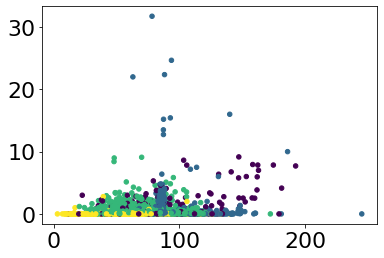

avg_length - favorite_count_std


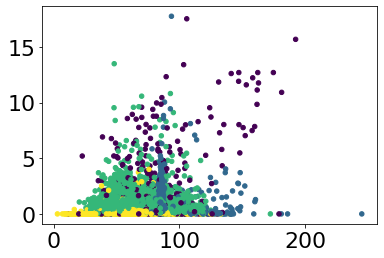

avg_length - favorite_count_entropy


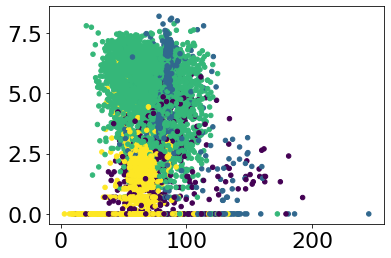

avg_length - retweet_count_mean


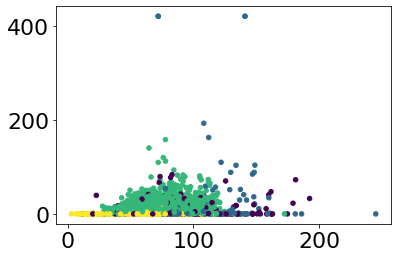

avg_length - retweet_count_std


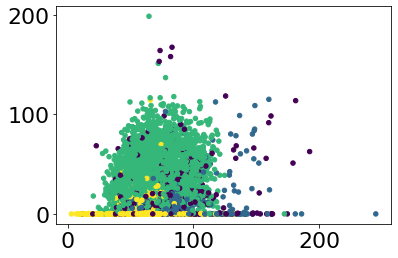

avg_length - retweet_count_entropy


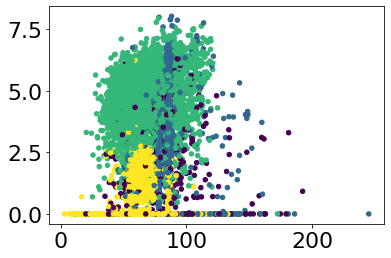

avg_special_chars - urls_ratio


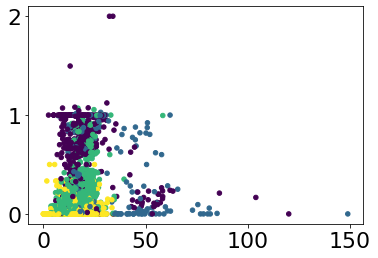

avg_special_chars - mentions_ratio


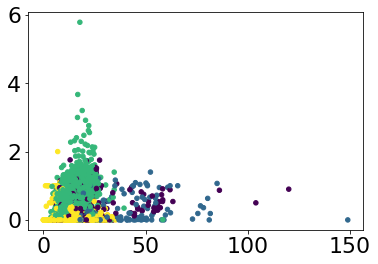

avg_special_chars - hashtags_ratio


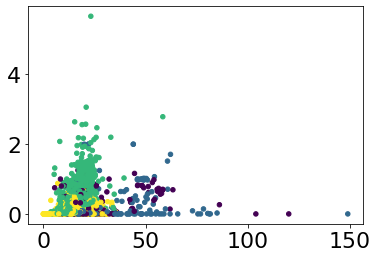

avg_special_chars - reply_count_mean


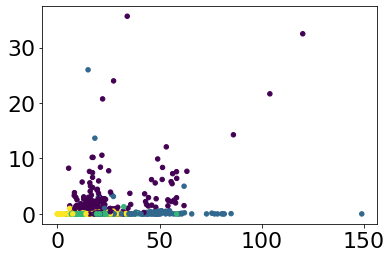

avg_special_chars - reply_count_std


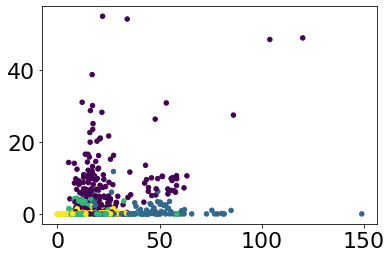

avg_special_chars - reply_count_entropy


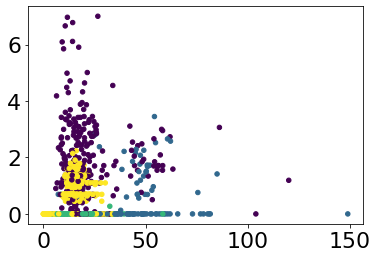

avg_special_chars - favorite_count_mean


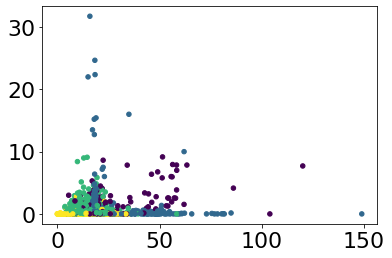

avg_special_chars - favorite_count_std


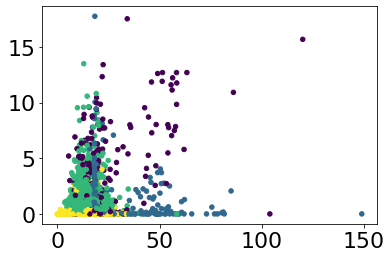

avg_special_chars - favorite_count_entropy


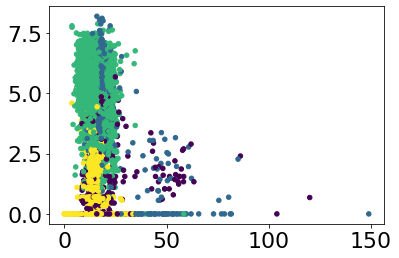

avg_special_chars - retweet_count_mean


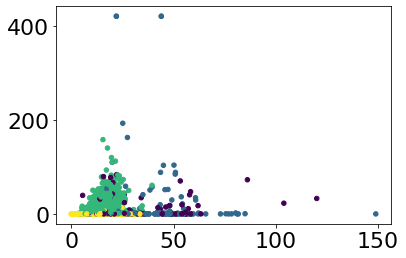

avg_special_chars - retweet_count_std


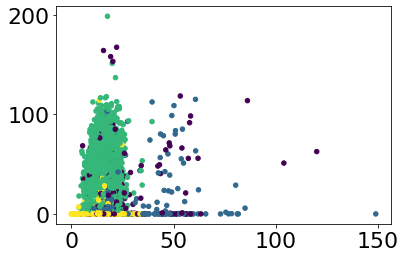

avg_special_chars - retweet_count_entropy


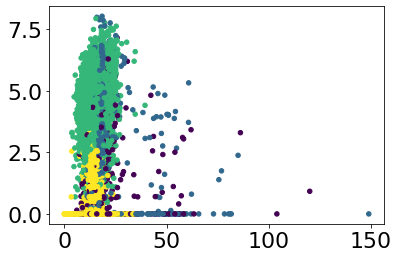

urls_ratio - mentions_ratio


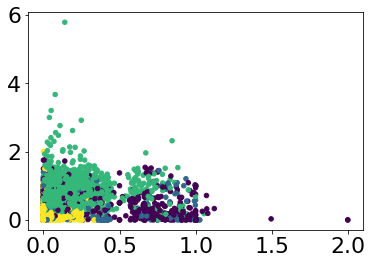

urls_ratio - hashtags_ratio


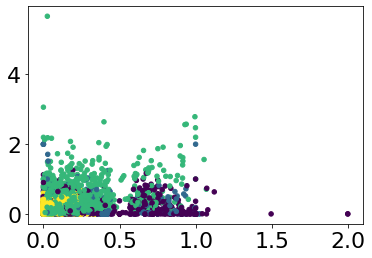

urls_ratio - reply_count_mean


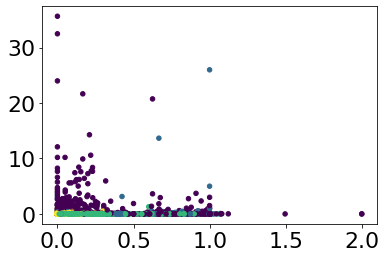

urls_ratio - reply_count_std


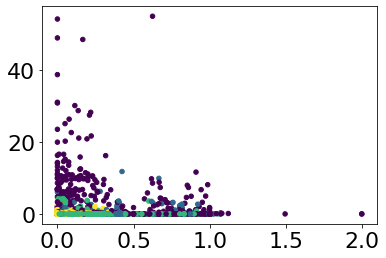

urls_ratio - reply_count_entropy


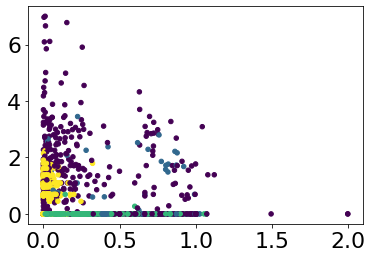

urls_ratio - favorite_count_mean


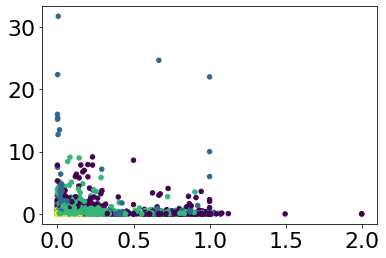

urls_ratio - favorite_count_std


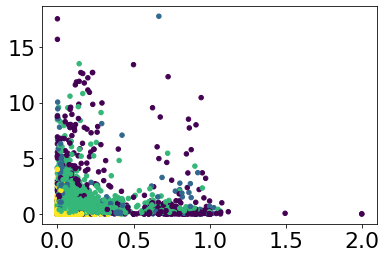

urls_ratio - favorite_count_entropy


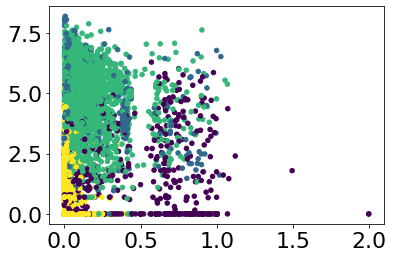

urls_ratio - retweet_count_mean


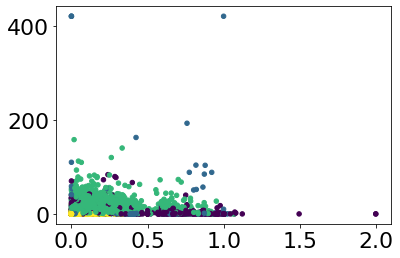

urls_ratio - retweet_count_std


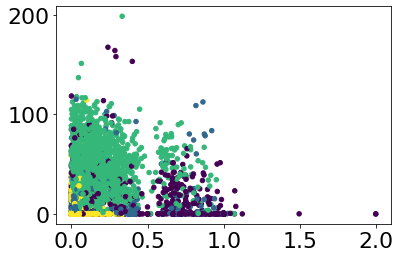

urls_ratio - retweet_count_entropy


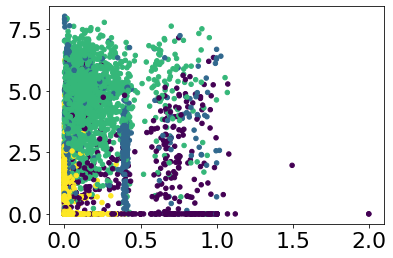

mentions_ratio - hashtags_ratio


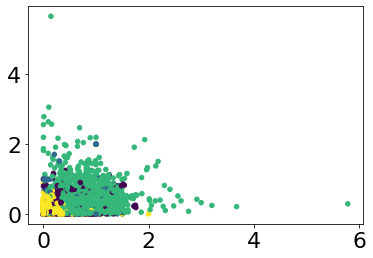

mentions_ratio - reply_count_mean


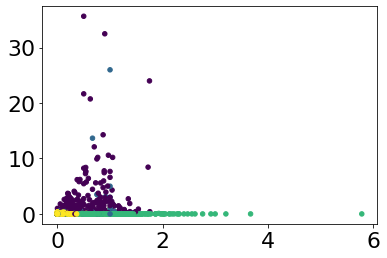

mentions_ratio - reply_count_std


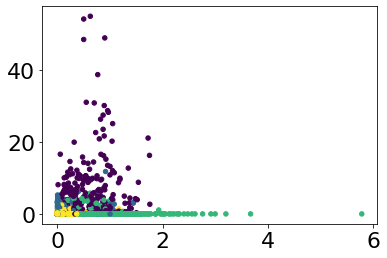

mentions_ratio - reply_count_entropy


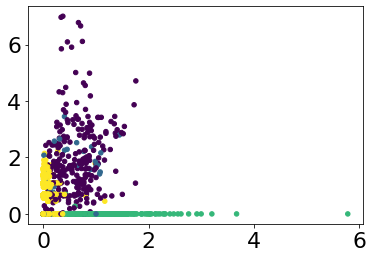

mentions_ratio - favorite_count_mean


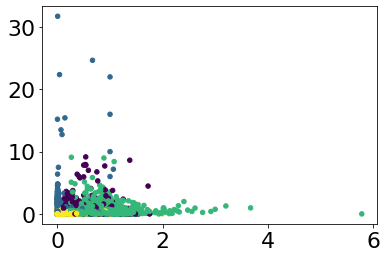

mentions_ratio - favorite_count_std


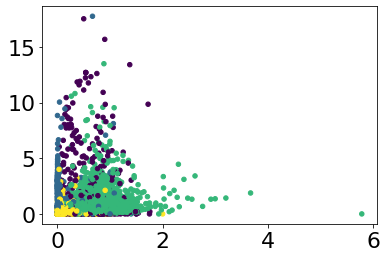

mentions_ratio - favorite_count_entropy


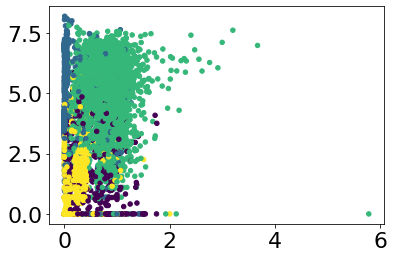

mentions_ratio - retweet_count_mean


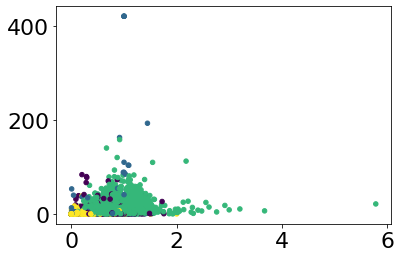

mentions_ratio - retweet_count_std


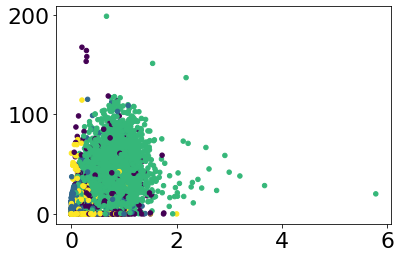

mentions_ratio - retweet_count_entropy


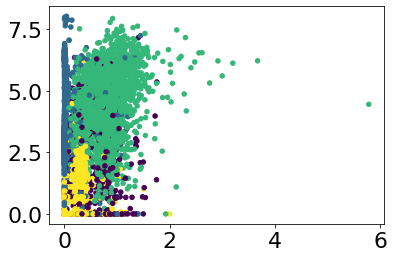

hashtags_ratio - reply_count_mean


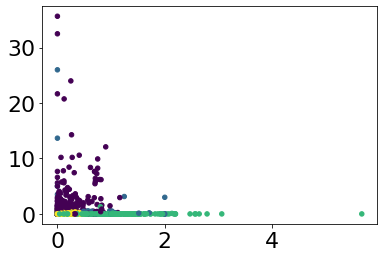

hashtags_ratio - reply_count_std


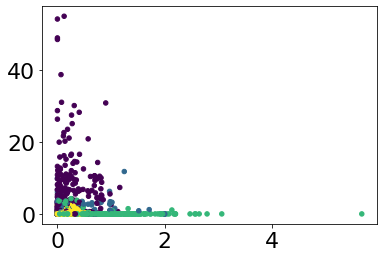

hashtags_ratio - reply_count_entropy


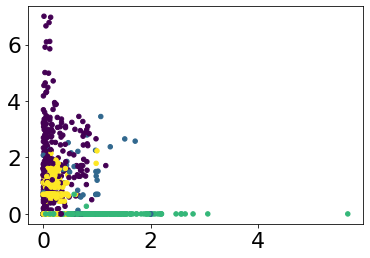

hashtags_ratio - favorite_count_mean


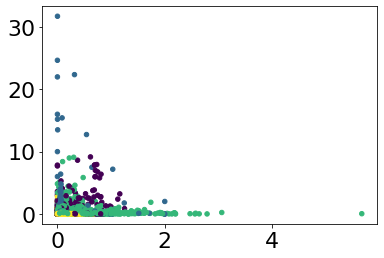

hashtags_ratio - favorite_count_std


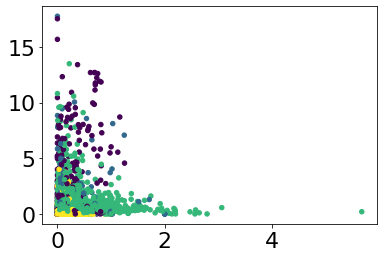

hashtags_ratio - favorite_count_entropy


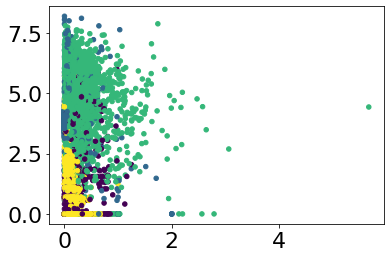

hashtags_ratio - retweet_count_mean


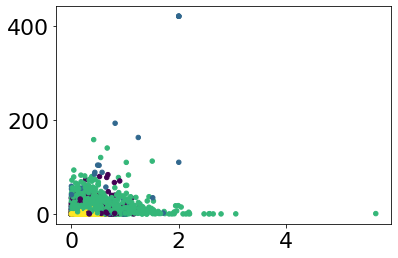

hashtags_ratio - retweet_count_std


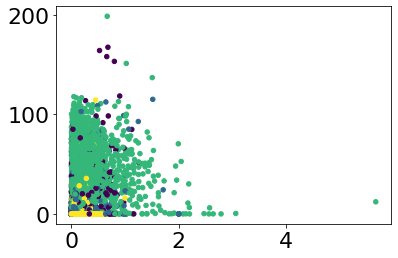

hashtags_ratio - retweet_count_entropy


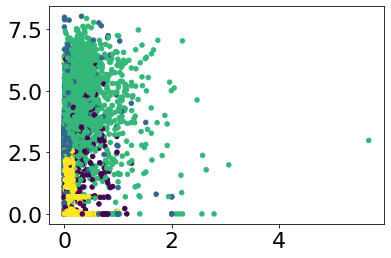

reply_count_mean - reply_count_std


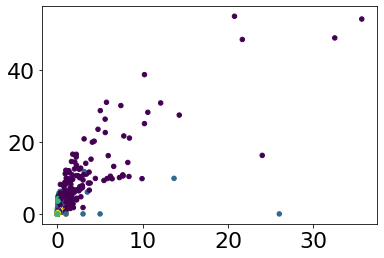

reply_count_mean - reply_count_entropy


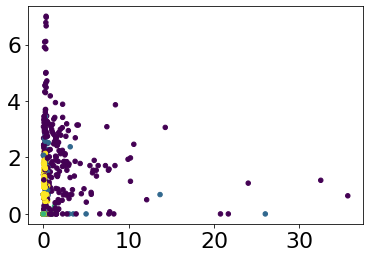

reply_count_mean - favorite_count_mean


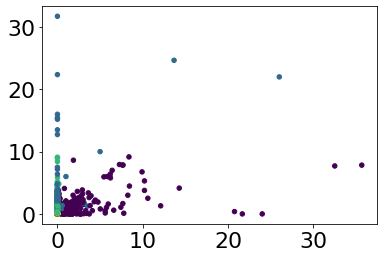

reply_count_mean - favorite_count_std


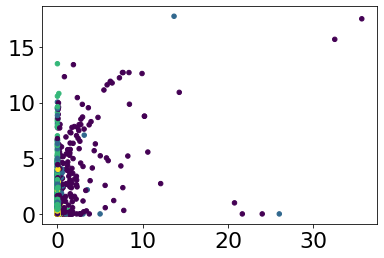

reply_count_mean - favorite_count_entropy


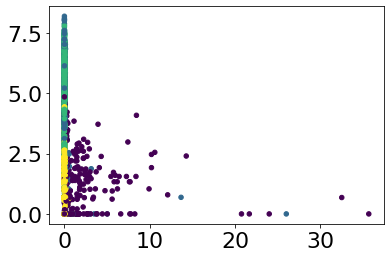

reply_count_mean - retweet_count_mean


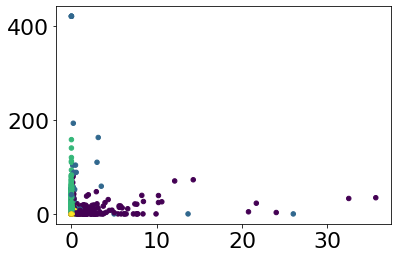

reply_count_mean - retweet_count_std


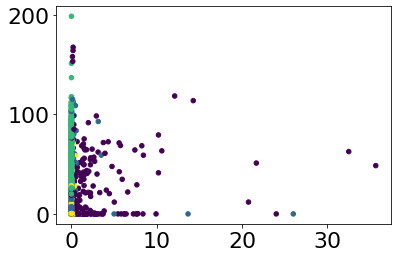

reply_count_mean - retweet_count_entropy


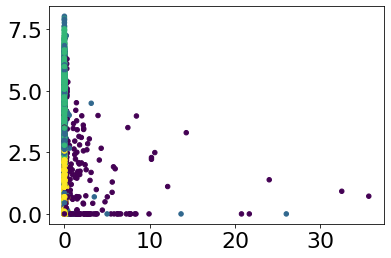

reply_count_std - reply_count_entropy


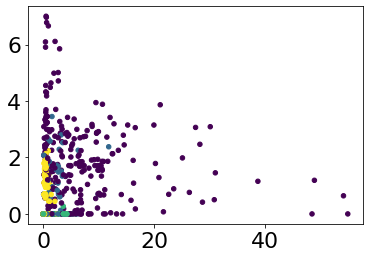

reply_count_std - favorite_count_mean


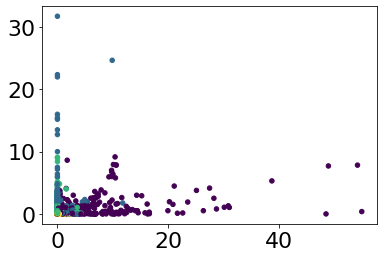

reply_count_std - favorite_count_std


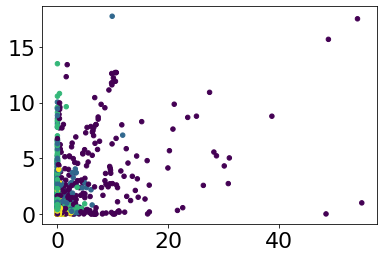

reply_count_std - favorite_count_entropy


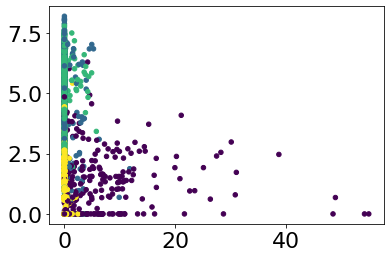

reply_count_std - retweet_count_mean


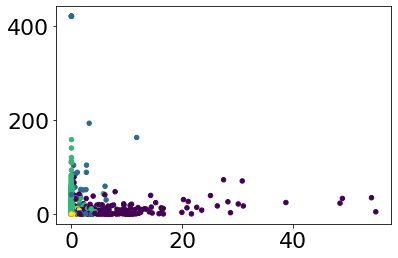

reply_count_std - retweet_count_std


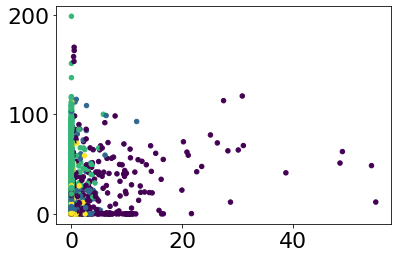

reply_count_std - retweet_count_entropy


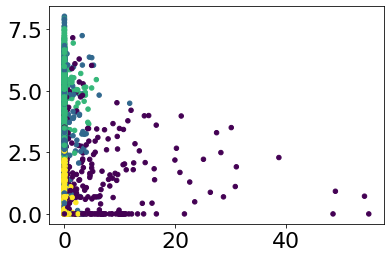

reply_count_entropy - favorite_count_mean


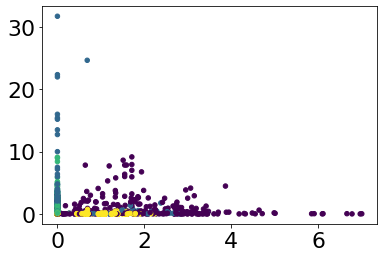

reply_count_entropy - favorite_count_std


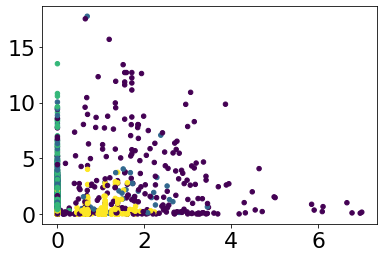

reply_count_entropy - favorite_count_entropy


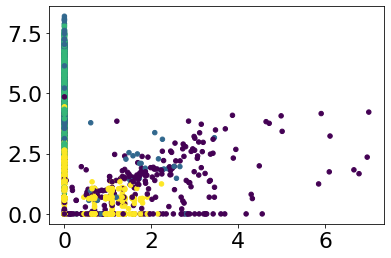

reply_count_entropy - retweet_count_mean


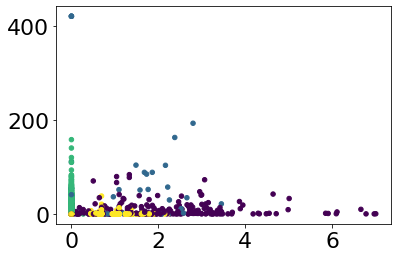

reply_count_entropy - retweet_count_std


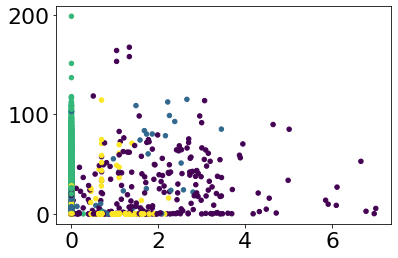

reply_count_entropy - retweet_count_entropy


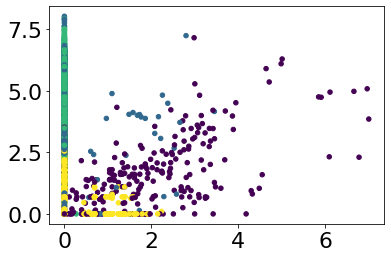

favorite_count_mean - favorite_count_std


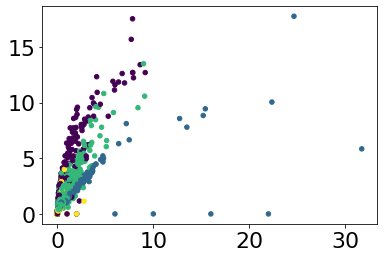

favorite_count_mean - favorite_count_entropy


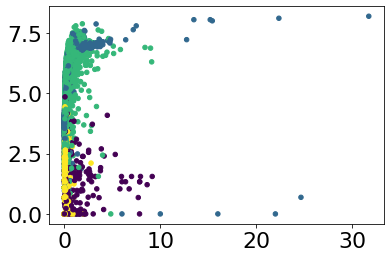

favorite_count_mean - retweet_count_mean


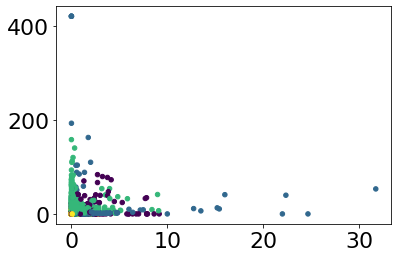

favorite_count_mean - retweet_count_std


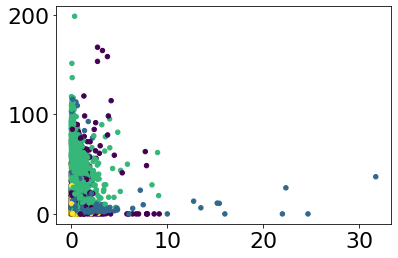

favorite_count_mean - retweet_count_entropy


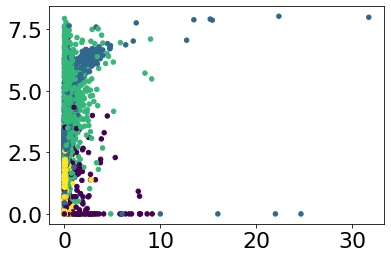

favorite_count_std - favorite_count_entropy


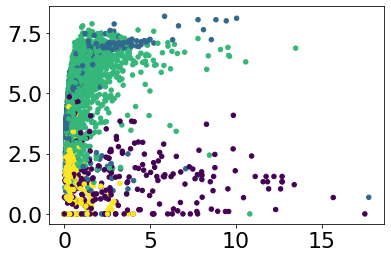

favorite_count_std - retweet_count_mean


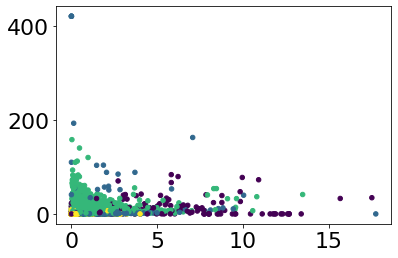

favorite_count_std - retweet_count_std


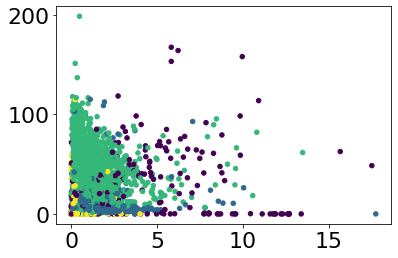

favorite_count_std - retweet_count_entropy


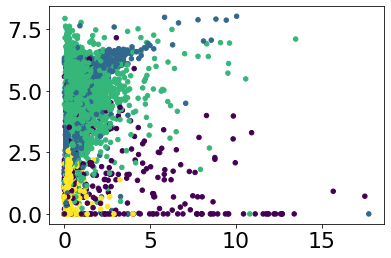

favorite_count_entropy - retweet_count_mean


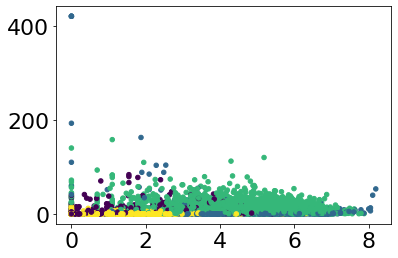

favorite_count_entropy - retweet_count_std


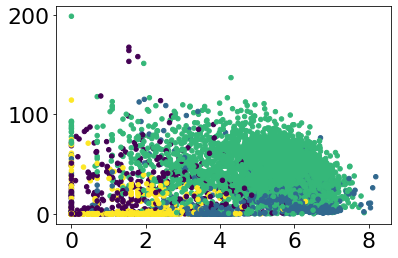

favorite_count_entropy - retweet_count_entropy


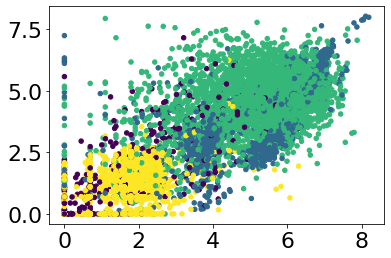

retweet_count_mean - retweet_count_std


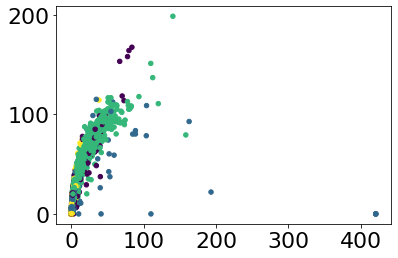

retweet_count_mean - retweet_count_entropy


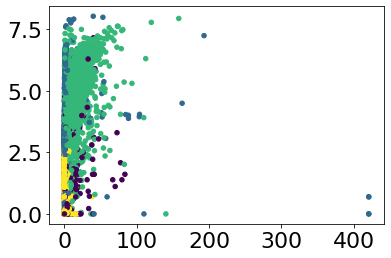

retweet_count_std - retweet_count_entropy


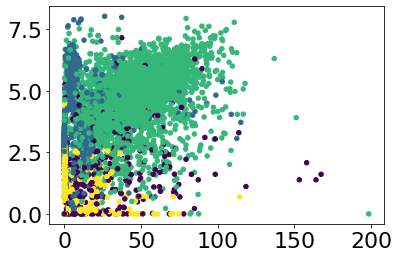

In [28]:
scatter_features_clusters(df, res_cluster.labels_)

# dbscan

In [114]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [34]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(X, 'euclidean') #vector containing all the distances among points
dist = squareform(dist) #matrix of the distances

In [35]:
kth_distances = []
for i in range(2,10):
    kth_distances.append(list())
for d in dist:
    index_kth_distance = []
    for i in range(len(kth_distances)):
        index_kth_distance.append(np.argsort(d)[i + 2]) #Return the indice of the k-th neighbor
    i = 0
    for l in kth_distances:
        l.append(d[index_kth_distance[i]]) #Appending the distance of the k-th ordered indice
        i += 1

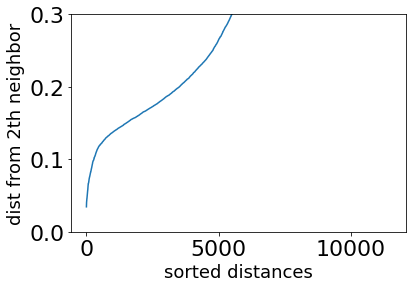

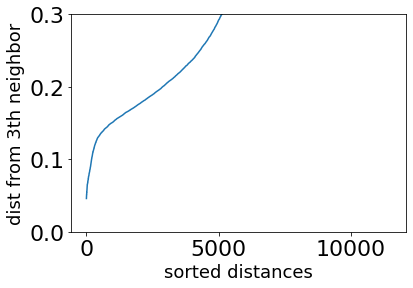

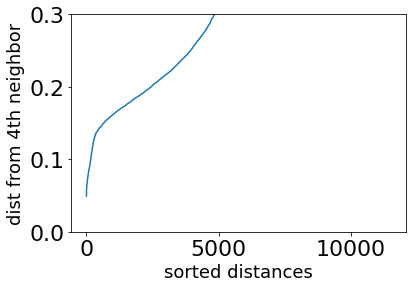

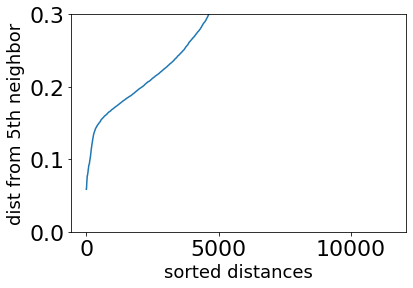

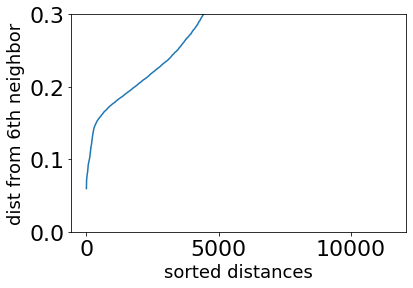

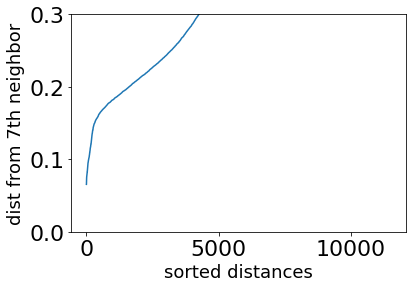

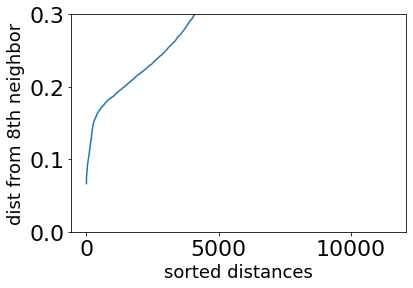

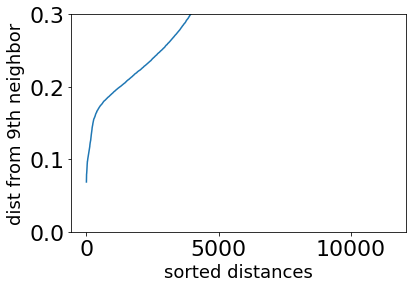

In [36]:
counter = 0
for i in kth_distances:
    plt.plot(range(0, len(i)), sorted(i))
    plt.ylabel('dist from %sth neighbor' % str(counter + 2), fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.ylim([0,0.3])
    plt.show()
    counter += 1

In [115]:
dbscan = DBSCAN(eps=0.12, min_samples=7)
dbscan.fit(X)

DBSCAN(eps=0.12, min_samples=7)

In [116]:
dbscan.labels_[:5]

array([-1, -1, -1, -1, -1], dtype=int64)

In [117]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([11252,   256], dtype=int64))

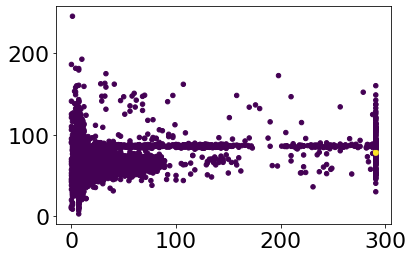

In [118]:
plt.scatter(df['statuses_count'], df['avg_length'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [119]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.17135352113786856


In [120]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

[1.12727602 4.23393259 3.24195319 ... 4.91008434 6.4604434  4.37379948]

[[0.         1.12727602 4.23393259 ... 4.80506642 0.69577728 4.61007733]
 [1.12727602 0.         4.48481254 ... 4.76138722 0.72754364 4.6617489 ]
 [4.23393259 4.48481254 0.         ... 5.47078865 4.29976934 5.76814969]
 ...
 [4.80506642 4.76138722 5.47078865 ... 0.         4.91008434 6.4604434 ]
 [0.69577728 0.72754364 4.29976934 ... 4.91008434 0.         4.37379948]
 [4.61007733 4.6617489  5.76814969 ... 6.4604434  4.37379948 0.        ]]


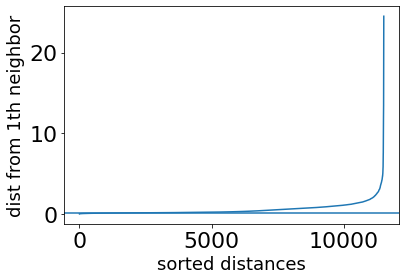

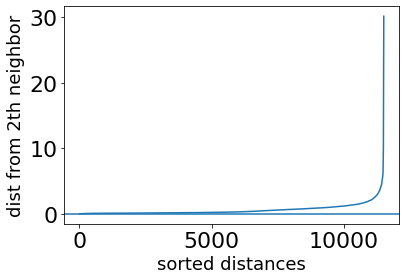

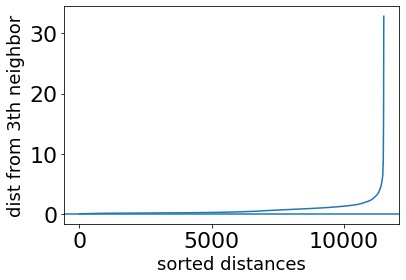

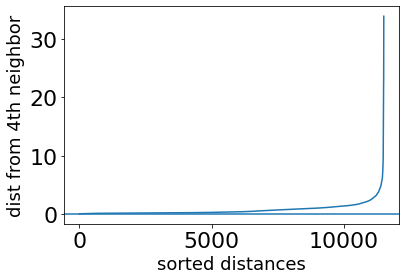

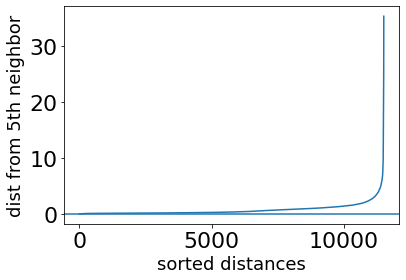

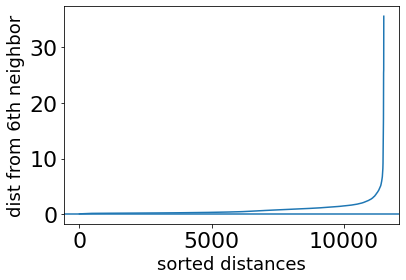

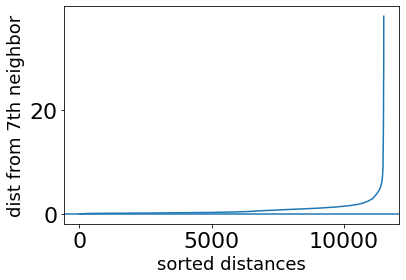

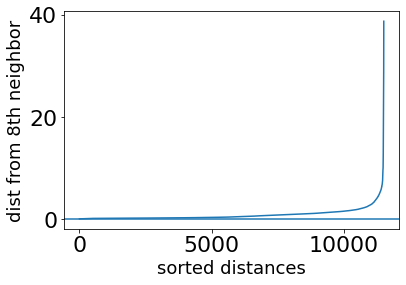

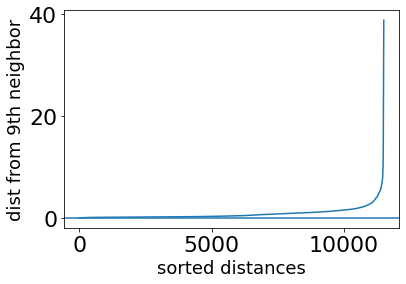

In [121]:
for k in range (1, 10):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
    plt.xlabel('sorted distances', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=22)
    plt.axhline(y=0.07)
    plt.show()

### Plot Cluster Results